# Compute files for cloud plots for models

In [1]:
%load_ext autoreload
%autoreload 2


from datetime import timedelta
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import useful_scit.util.log as log
import xarray as xr
from dask.diagnostics import ProgressBar

from bs_fdbck_clean.constants import path_extract_latlon_outdata

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [2]:
from bs_fdbck_clean.constants import path_measurement_data
from bs_fdbck_clean.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud
from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud, \
    rn_dic_noresm_cloud
from bs_fdbck_clean.util.BSOA_datamanip import fix_echam_time
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month
from bs_fdbck_clean.util.imports import import_fields_xr_echam

In [3]:
xr.set_options(keep_attrs=True)
log.ger.setLevel(log.log.INFO)

## General settings

In [4]:

select_station = 'ATTO'

calc_seasons = ['ALL_year']

tau_lims = [5, 50]
r_eff_lim = 1
cloud_top_temp_above = -15
cld_water_path_above = 50

postproc_data = path_measurement_data / 'model_station' / select_station
postproc_data_obs = path_measurement_data / select_station / 'processed'

In [5]:
lon_lims = [293., 308.]
lat_lims = [-8., -1.]

lat_station = -2.150
lon_station = 360 - 59.009
model_lev_i = -2

temperature = 273.15  # K

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 = '2015-01-01'
to_time2 = '2019-01-01'
sel_years_from_files = ['2012', '2014', '2015', '2018']

#### Model level different in UKESM because model has much finer resolution close to the ground 

In [6]:
model_lev_i_ukesm = -2

In [7]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f' % (*lon_lims,)
str_latlim = '%.1f-%.1f' % (*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

#### Daytime values


Set the daytime to be from 10 to 17 each day

In [8]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [9]:
models = ['UKESM','ECHAM-SALSA', 'NorESM', 'EC-Earth']

mod2cases = {'ECHAM-SALSA': ['SALSA_BSOA_feedback'],
             'NorESM': ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth': ['ECE3_output_Sara'],
             'UKESM':['AEROCOMTRAJ'],
             }
di_mod2cases = mod2cases.copy()

In [10]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        #if model_lev_i !=-2:
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}_ilev{model_lev_i}.csv'
        #else:
        #    fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'

        #fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_UKESM_AEROCOMTRAJ_ilev-2.csv
ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback_ilev-2.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp_ilev-2.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara_ilev-2.csv


In [11]:
dic_df_station = dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        #if model_lev_i !=-2:
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}_ilev{model_lev_i}.csv'
        #else:
        #    fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        # dic_df_mod_case[mod][ca].to_csv(fn_out)

UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_UKESM_AEROCOMTRAJ_ilev-2.csv
ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback_ilev-2.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp_ilev-2.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara_ilev-2.csv


In [12]:
pd.read_csv('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_UKESM_AEROCOMTRAJ_ilev-1.csv', index_col=0)

,lev,station,Mass_Conc_OM_AS,Mass_Conc_OM_CS,Mass_Conc_OM_KI,Mass_Conc_OM_KS,Mass_Conc_OM_NS,T,ddryAS,ddryCS,...,density,ambient2stp_correction_factor,OA_STP,N100_STP,N200_STP,N50_STP,N500_STP,N50-500_STP,N100-500_STP,N200-500_STP
time,,,,,,,,,,,,,,,,,,,,,
2011-12-31 20:00:00,2.0,ATTO,3.031003,4.716932e-11,0.000525,0.553099,9.942592e-08,303.77320,221.23042,976.79150,...,1.146782,1.126847,4.039326,1312.170293,581.371233,1759.930698,8.472793,1751.457906,1303.697501,572.898441
2011-12-31 23:00:00,2.0,ATTO,3.865207,5.230999e-11,0.002304,0.109804,1.045905e-07,303.04004,206.00742,978.76900,...,1.149557,1.124127,4.471008,1391.043028,696.932599,1709.466251,7.230156,1702.236095,1383.812872,689.702443
2012-01-01 02:00:00,2.0,ATTO,4.036749,5.384786e-11,0.011744,0.213789,7.461750e-08,302.00464,209.54840,979.79750,...,1.153498,1.120286,4.774976,1494.818136,722.987819,1932.078065,8.001361,1924.076704,1486.816775,714.986459
2012-01-01 05:00:00,2.0,ATTO,3.968944,5.155770e-11,0.017817,0.211973,7.988037e-07,300.91577,211.14984,971.15424,...,1.157672,1.116247,4.686827,1453.273885,703.171720,1956.599971,8.108950,1948.491021,1445.164936,695.062771
2012-01-01 08:00:00,2.0,ATTO,4.094418,5.640456e-11,0.000000,0.283467,2.882110e-07,299.59912,221.51166,962.39935,...,1.162759,1.111363,4.865421,1324.359734,694.932094,1618.659986,10.237950,1608.422036,1314.121784,684.694143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31 05:00:00,2.0,ATTO,3.104124,3.624661e-11,0.004008,0.129250,0.000000e+00,302.67627,203.98842,783.04780,...,1.150938,1.122778,3.634860,1154.110537,553.144419,1378.583995,4.762979,1373.821016,1149.347557,548.381440
2019-01-31 08:00:00,2.0,ATTO,3.233153,3.746464e-11,0.000000,0.157053,0.000000e+00,300.24830,216.29216,800.81900,...,1.160245,1.113771,3.775913,1008.219146,542.911938,1132.357752,6.456064,1125.901688,1001.763081,536.455873
2019-01-31 11:00:00,2.0,ATTO,2.462666,2.984830e-11,0.000034,0.302983,0.000000e+00,303.69970,209.91815,832.73060,...,1.147059,1.126574,3.115747,1035.188002,469.176043,1294.259872,4.868780,1289.391092,1030.319222,464.307263


## Calculate datasets for each model

# NorESM

In [13]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [14]:
cases = [case_name]

#### Path input data

In [15]:
path_input_data_noresm = path_extract_latlon_outdata / case_name

#### Filenames to store products in 3d/2d

In [16]:
# Filename for case1 concatinated over time 
fn1 = path_extract_latlon_outdata / case_name1 / f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_{str_coordlims}.nc'

# Select variables and time: 
fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'
# Sortby time: 
fn1_3 = fn1.parent / f'{fn1.stem}_sort3.nc'

# Filename for case1 concatinated over time 

fn2 = path_extract_latlon_outdata / case_name2 / f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_{str_coordlims}.nc'

# Select variables and time: 
fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'
# Sortby time: 
fn2_3 = fn2.parent / f'{fn2.stem}_sort3.nc'

# Concatinated case1 and case2 
fn_comb = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
# Concatinated only 

# fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1.nc'
fn_comb_lev1_final = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_comb_lev1_finaler = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finaler.nc'
fn_comb_lev1_final_csv = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final_wet_season.csv'
fn_final_csv_stem = path_input_data_noresm / f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.csv'

In [17]:
print(fn_comb_lev1_final_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_final_wet_season.csv


#### Define NorESM station variables and cloud variables

In [18]:
varl_st = ['SOA_NA', 'SOA_A1', 'OM_NI', 'OM_AI', 'OM_AC', 'SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC', 'SO4_PR',
           'BC_N', 'BC_AX', 'BC_NI', 'BC_A', 'BC_AI', 'BC_AC', 'SS_A1', 'SS_A2', 'SS_A3', 'DST_A2', 'DST_A3',
           'N50', 'N100', 'N150', 'N200', 'N500',
           #           'N50-500','N100-500', 'N150-500', 'N200-500',
           # 'OA',
           ]
varl_st_computed = ['OA', 'OA_STP', 'OA_amb', 'T_C',  
                    'N50_STP', 'N100_STP', 'N150_STP', 'N200_STP', 'N500_STP',
                    'N50-500_STP', 'N100-500_STP', 'N150-500_STP', 
                    'N200-500_STP', 'N500_STP',
                   ]

varl_cl = ['TOT_CLD_VISTAU', 'TOT_ICLD_VISTAU', 'TGCLDCWP', 'TGCLDLWP', 'TGCLDIWP',
           'TOT_CLD_VISTAU_s', 'TOT_ICLD_VISTAU_s', 'optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL', 'ACTNL', 'TGCLDLWP',
           'FSDSC', 'FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC', 'FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

#### Concatinate files, compute 2D fields from 3D fields (compute tau) and sortby time.

In [19]:
fn_comb.exists()

True

In [20]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks={'time': 96}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks={'time': 96}, engine='netcdf4')

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)

        varl = list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0], sel_years_from_files[1]))  # .sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2], sel_years_from_files[3]))  # .sortby('time')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()

    if not fn1_3.exists():
        ds_mod1 = xr.open_dataset(fn1_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod1 = compute_total_tau(ds_mod1)
        ds_mod1 = ds_mod1.isel(lev=model_lev_i)
        ds_mod1 = ds_mod1.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
        print('hey 1')
        with ProgressBar():
            results = delayed_obj.compute()
    if not fn2_3.exists():
        ds_mod2 = xr.open_dataset(fn2_2, chunks={'time': 48}, engine='netcdf4')  # [fn1,fn2])#.sortby('time')
        ds_mod2 = compute_total_tau(ds_mod2)
        ds_mod2 = ds_mod2.isel(lev=model_lev_i)
        ds_mod2 = ds_mod2.sortby('time')  # .sel(time=slice('2012','2014'))
        delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
        print('hey')
        with ProgressBar():
            results = delayed_obj.compute()

    ds_mod = xr.open_mfdataset([fn1_3, fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True, )

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute=False)
    with ProgressBar():
        results = delayed_obj.compute()

    # ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

In [21]:
fn1_3.exists()

False

In [22]:
fn2_3.exists()

True

In [23]:
fn_comb

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc')

##### Check: 

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


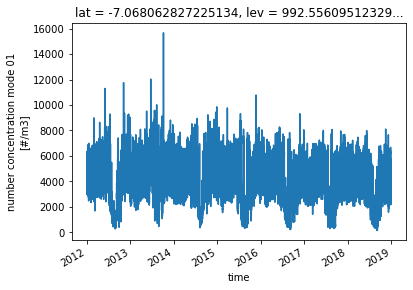

In [24]:
ds_mod = xr.open_dataset(fn_comb, engine='netcdf4', chunks={'time': 48})
(1e-6 * ds_mod['NCONC01'].isel(lat=0, lon=0)).plot()

#### Change units and compute variables

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [25]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb, engine='netcdf4').isel(ilev=model_lev_i)
    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
        nbnd=0
    ).squeeze()
    # ds_all = broadcase_station_data(ds_all, lon = lon_station, lat = lat_station)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)

    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [26]:
df_comb_station = dic_df_station['NorESM']['OsloAero_intBVOC_f09_f09_mg17_fssp']
df_comb_station.head()

,station,ACTREL,lev,BC_A,BC_AC,BC_AI,BC_AX,BC_N,BC_NI,COAGNUCL,...,year,density,ambient2stp_correction_factor,N100_STP,N200_STP,N50_STP,N500_STP,N50-500_STP,N100-500_STP,N200-500_STP
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 19:00:00,ATTO,0.0,976.325407,5.815709e-12,2.284618e-12,6.216762e-12,1.086100e-14,7.984544e-14,2.962090e-15,0.000015,...,2012,1.164894,1.109326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 20:00:00,ATTO,0.0,976.325407,5.740620e-12,2.293239e-12,6.177176e-12,1.259311e-14,9.083385e-14,3.465085e-15,0.000015,...,2012,1.164639,1.109569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 21:00:00,ATTO,0.0,976.325407,5.691387e-12,2.298453e-12,6.137951e-12,1.367037e-14,9.720762e-14,3.823664e-15,0.000015,...,2012,1.164454,1.109746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 22:00:00,ATTO,0.0,976.325407,5.694673e-12,2.315673e-12,6.140177e-12,1.463017e-14,1.042964e-13,4.151001e-15,0.000015,...,2012,1.164385,1.109811,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 23:00:00,ATTO,0.0,976.325407,5.788481e-12,2.355007e-12,6.202035e-12,1.578037e-14,1.137945e-13,4.455077e-15,0.000015,...,2012,1.164594,1.109612,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Open dataset computed above

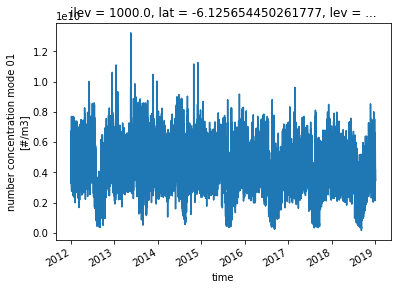

In [27]:

ds_all = xr.open_dataset(fn_comb_lev1_final, chunks={'lon': 1}, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['NCONC01'].isel(lat=1, lon=1).plot()

#### *Mask if ice water path more than 5% of total water path

In [28]:
mask_liq_cloudtop = (ds_all['FCTL']>0.05) & (ds_all['FCTL']/(ds_all['FCTL']+ds_all['FCTI'])>.8)

mask_liq_cloudtop
ds_all['mask_liq_cloudtop'] = mask_liq_cloudtop
#ds_all = ds_all.where(mask_liq_cloudtop)

In [29]:
ds_all['frac_lwp2cwp'] = ds_all['TGCLDLWP']/(ds_all['TGCLDIWP']+ds_all['TGCLDLWP'])
ds_all['mask_by_lwp2cwp'] = ds_all['frac_lwp2cwp']>0.95

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


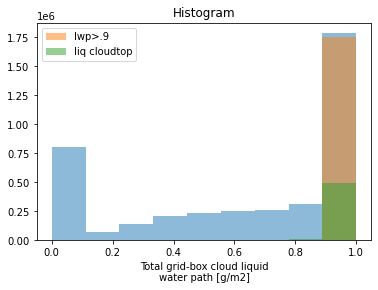

In [30]:
ds_all['frac_lwp2cwp'].plot.hist(alpha=0.5,bins=np.linspace(0,1,10))

ds_all['frac_lwp2cwp'].where(ds_all['frac_lwp2cwp']>0.9).plot.hist(alpha=0.5, bins=np.linspace(0,1,10),label='lwp>.9')
ds_all['frac_lwp2cwp'].where(ds_all['mask_liq_cloudtop']).plot.hist(alpha=0.5, bins=np.linspace(0,1,10), label='liq cloudtop')

plt.legend()

In [31]:
ds_all= ds_all.where(ds_all['mask_by_lwp2cwp'])

#### * Mask if cloud top fraction of liquid is below 10 %

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(array([ 29337.,  19610.,  19400.,  16425.,  29244.,  14261.,  17469.,
         16205.,  19445., 165845.]),
 array([0.10000036, 0.19000033, 0.2800003 , 0.37000024, 0.46000022,
        0.5500002 , 0.64000016, 0.7300001 , 0.82000005, 0.91      ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

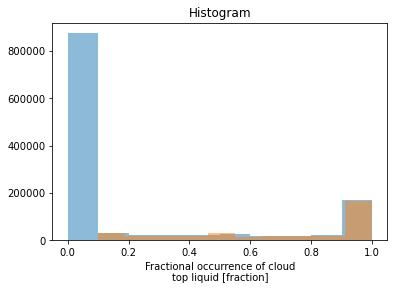

In [32]:
ds_all['FCTL'].where(ds_all['TGCLDCWP_incld']>50).plot(alpha=.5)
ds_all.where(ds_all['FCTL']>.1)['FCTL'].where(ds_all['TGCLDCWP_incld']>50).plot(alpha=.5)

In [33]:
ds_all = ds_all.where(ds_all['FCTL']>.1)

#### NorESM Shift time step to start of period to be consistent with measurements and other models

In [34]:
#ind = df.index
#df.index = ind - datetime.timedelta(hours=1)
if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=1)
    #ds_all['time'].attrs['timezone'] = 'utc+2'
    ds_all['time'].attrs['timezone'] = 'utc'
    
    print('shifted time by -1 for NorESM')

shifted time by -1 for NorESM


#### Shift timezone

In [35]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

[##################                      ] | 46% Completed | 45.0s

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 47.9s
shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [36]:
ds_smll = ds_all[['NCONC01']]

In [37]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [38]:
varl_tmp = varl_st + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [39]:
varl_tmp = varl_st + varl_st_computed
set(df_comb_station.columns).intersection(set(varl_tmp))

{'BC_A',
 'BC_AC',
 'BC_AI',
 'BC_AX',
 'BC_N',
 'BC_NI',
 'DST_A2',
 'DST_A3',
 'N100-500_STP',
 'N100_STP',
 'N150',
 'N200-500_STP',
 'N200_STP',
 'N50-500_STP',
 'N500_STP',
 'N50_STP',
 'OA_STP',
 'OM_AC',
 'OM_AI',
 'OM_NI',
 'SO4_A1',
 'SO4_A2',
 'SO4_AC',
 'SO4_NA',
 'SO4_PR',
 'SOA_A1',
 'SOA_NA',
 'SS_A1',
 'SS_A2',
 'SS_A3',
 'T_C'}

In [40]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

SOA_NA
replacing SOA_NA 
SOA_A1
replacing SOA_A1 
OM_NI
replacing OM_NI 
OM_AI
replacing OM_AI 
OM_AC
replacing OM_AC 
SO4_NA
replacing SO4_NA 
SO4_A1
replacing SO4_A1 
SO4_A2
replacing SO4_A2 
SO4_AC
replacing SO4_AC 
SO4_PR
replacing SO4_PR 
BC_N
replacing BC_N 
BC_AX
replacing BC_AX 
BC_NI
replacing BC_NI 
BC_A
replacing BC_A 
BC_AI
replacing BC_AI 
BC_AC
replacing BC_AC 
SS_A1
replacing SS_A1 
SS_A2
replacing SS_A2 
SS_A3
replacing SS_A3 
DST_A2
replacing DST_A2 
DST_A3
replacing DST_A3 
N50
Did not find N50. Skipping
N100
Did not find N100. Skipping
N150
replacing N150 
N200
Did not find N200. Skipping
N500
Did not find N500. Skipping
OA
Did not find OA. Skipping
OA_STP
replacing OA_STP 
OA_amb
Did not find OA_amb. Skipping
T_C
replacing T_C 
N50_STP
replacing N50_STP 
N100_STP
replacing N100_STP 
N150_STP
Did not find N150_STP. Skipping
N200_STP
replacing N200_STP 
N500_STP
replacing N500_STP 
N50-500_STP
replacing N50-500_STP 
N100-500_STP
replacing N100-500_STP 
N150-500_STP
Di

#### Replace all values by station values

In [41]:
for v in varl_tmp:
    if v not in ds_smll:
        print(f'skipping {v} because not in dataset')
        continue
    ds_all[v] = ds_smll[v]

skipping N50 because not in dataset
skipping N100 because not in dataset
skipping N200 because not in dataset
skipping N500 because not in dataset
skipping OA because not in dataset
skipping OA_amb because not in dataset
skipping N150_STP because not in dataset
skipping N150-500_STP because not in dataset


##### Controle plots

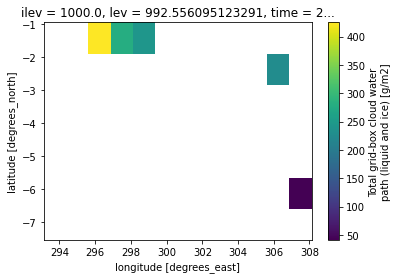

In [42]:
ds_all['TGCLDCWP_incld'].sel(time='2012-05-30 02:00:00').plot()

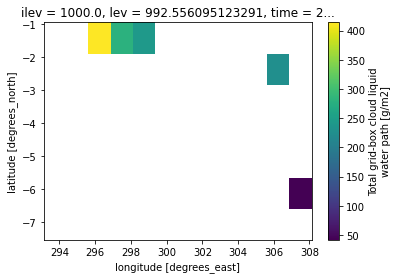

In [43]:
ds_all['TGCLDLWP_incld'].sel(time='2012-05-30 02:00:00').plot()

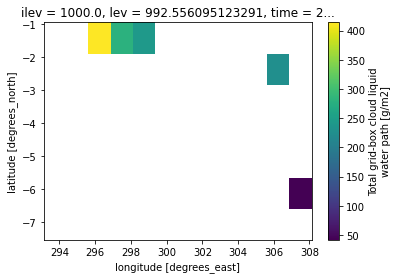

In [44]:
ds_all['TGCLDLWP_incld'].sel(time='2012-05-30 02:00:00').plot()

#### Finally steps

In [45]:
dic_ds = dict()
dic_ds[case_name_noresm] = ds_all

##### Rename vars

In [46]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)

#### Save netcdf file

In [47]:
if True:#not :#fn_comb_lev1_finaler.exists():
    with ProgressBar():
        dic_ds[case_name_noresm].to_netcdf(fn_comb_lev1_finaler)

#### Controle plots

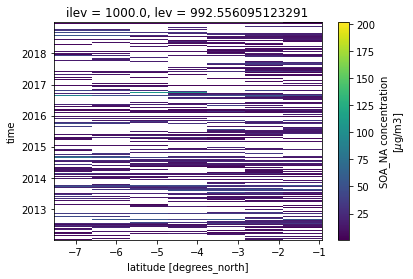

In [48]:
dic_ds[case_name_noresm]['OA'].mean('lon').plot()

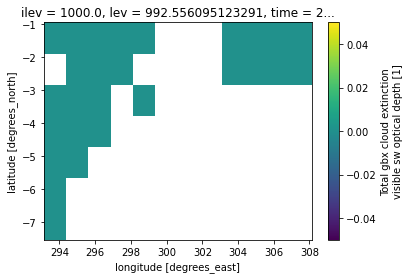

In [49]:
dic_ds[case_name_noresm]['COT'].sel(time='2018-01-07 00:00:00').plot()

(0.0, 400.0)

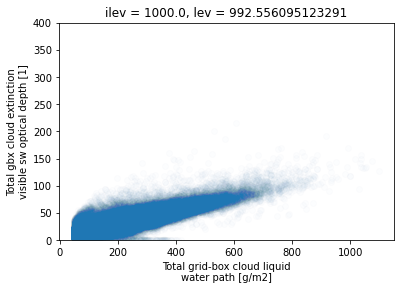

In [50]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='CWP', y='COT', alpha=0.01)
plt.ylim([0, 400])

(0.0, 400.0)

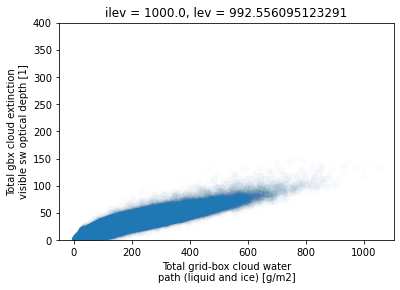

In [51]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']

_ds.where(_ds['COT'] > 0).where(_ds['CWP'] > 50).plot.scatter(x='TGCLDCWP', y='TOT_CLD_VISTAU_s', alpha=0.01)
plt.ylim([0, 400])

#### Save final csv

In [52]:
ds_noresm = ds_all.copy()

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


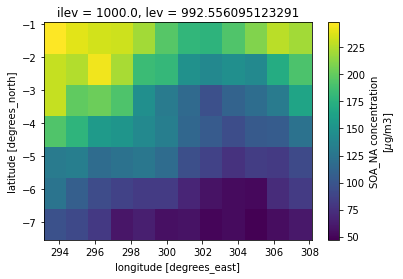

merge
df1
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv
202.85917329601943
DONE! That took 202.85917329601943 seconds
That is  3.380986221600324 minuts


In [53]:
for seas in calc_seasons:
    _fn_csv = fn_final_csv_stem.parent / (fn_final_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:# not _fn_csv.exists():
        start = timer()

        dic_df = get_dic_df_mod(
            dic_ds,
            select_hours_clouds=True,
            summer_months=season2month[seas],
            from_hour=daytime_from,
            # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50]),
            kwrgs_mask_clouds=dict(min_reff = r_eff_lim, min_cwp=cld_water_path_above, tau_bounds=tau_lims),

            # kwrgs_mask_clouds = dict(min_reff = 1),
            to_hour=daytime_to,
        )

        df_mod = dic_df[case_name_noresm]

        # df_mod= df_mod.dropna()
        print(_fn_csv)
        df_mod.to_csv(_fn_csv)
        end = timer()
        print(end - start)  # Time in seconds, e.g. 5.38091952400282
        print(f'DONE! That took {(end - start)} seconds')
        print(f'That is  {((end - start) / 60)} minuts')

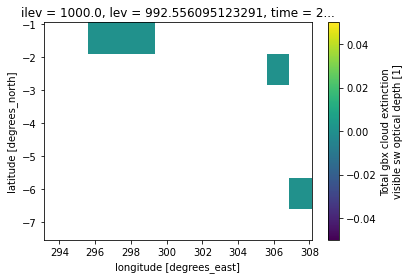

In [54]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 02:00:00').plot()

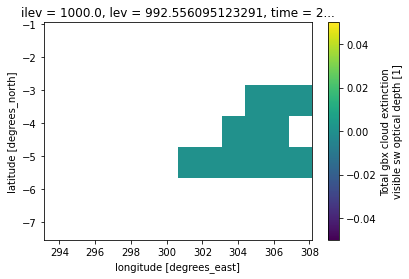

In [55]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time='2012-05-30 23:00:00').plot()

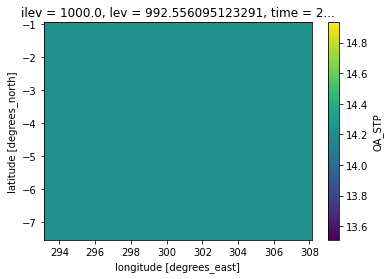

In [56]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA_STP'].sel(time='2012-05-30 02:00:00').plot()

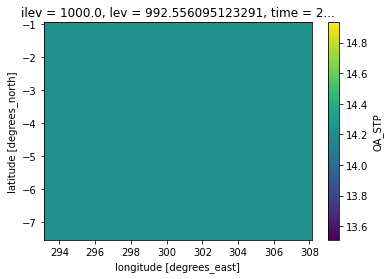

In [57]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['OA_STP'].sel(time='2012-05-30 02:00:00').plot()

# ECHAM-SALSA

#### Names etc

In [58]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res = 'locations'
model_name = 'ECHAM-SALSA'
model_name_echam = 'ECHAM-SALSA'

#### Input path 

In [59]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam

In [60]:

cases_echam = [case_name_echam]

#### Station variables  and others

In [61]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
    'N50',
    'N100',
    'N200',
    'N500',
    'N50-500',
    'N100-500',
    'N200-500',
    'N50_STP',
    'N100_STP',
    'N200_STP',
    'N500_STP',
    'N50-500_STP',
    'N100-500_STP',
    'N200-500_STP',

]

varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    # 'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
    'tempair',
    'tempair_ct',
    'T_ct',

]



#### Filenames: 

In [62]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

In [63]:
fl_open = []

for v in varl_cl_echam + varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    # print(fn)
    if fn.exists():
        fl_open.append(fn)
    else:
        print(f'{v} not found')

tempair_ct not found
T_ct not found
mmrtrN500 not found
mmrtrN250 not found
mmrtrN3 not found
SO2_gas not found
APIN_gas not found
TBETAOCI_gas not found
BPIN_gas not found
LIMON_gas not found
SABIN_gas not found
MYRC_gas not found
CARENE3_gas not found
ISOP_gas not found
VBS0_gas not found
V*BS1_gas not found
VBS10_gas not found
oh_con not found
N50 not found
N100 not found
N200 not found
N500 not found
N50-500 not found
N100-500 not found
N200-500 not found
N50_STP not found
N100_STP not found
N200_STP not found
N500_STP not found
N50-500_STP not found
N100-500_STP not found
N200-500_STP not found


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [64]:
fl_open = list(set(fl_open))

In [65]:
ds_all = xr.open_mfdataset(fl_open, decode_cf=False)

In [66]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf=False)
    # ds_iso = xr.open_dataset(fl_open[21])
    # ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)

    # ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all)

    # ds_sel = ds_all.sel(lat = lat_station, lon= lon_station, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all = ds_all.drop(['hyai', 'hybi', 'hyam', 'hybm']).squeeze()
    ds_all = ds_all.isel(lev=model_lev_i)

    # ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_station, lat = lat_station)

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


#### Add variables from station data to imitate using station measurements

In [67]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

#### Moved to preprocess: Compute Nx-500

for v in ['N50', 'N100', 'N200', 'N150', 'N25', 'N70', 'N250']:
    if v in df_comb_station.columns:
        df_comb_station[v + '-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v + '-500')
        print(v)

In [68]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

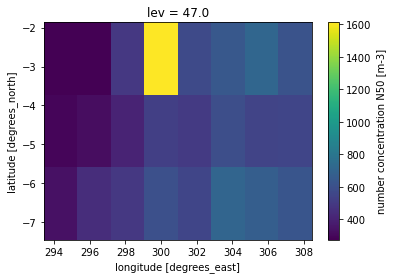

In [69]:
ds_all = xr.open_dataset(fn_final_echam, engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['N50'].mean('time').plot()  # .isel(lat=0, time=0).plot()#.shape#.plot()

In [70]:
ds_all['time'].attrs['timezone'] = 'utc'

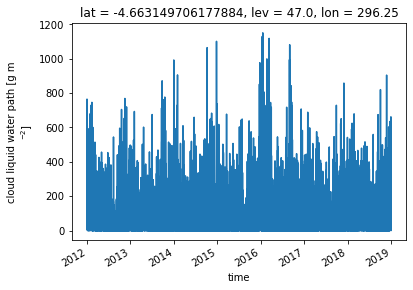

In [71]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

#### Fix time for echam

In [72]:
with xr.set_options(keep_attrs=True):
    attrs = ds_all['time'].attrs.copy()
    ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values
    ds_all['time'].attrs = attrs

#### Finally produce daily median dataset:

In [73]:
dic_ds = dict()
dic_ds[case_name] = ds_all

##### Controle plots

(array([5.64041e+05, 2.57119e+05, 1.49413e+05, 8.69250e+04, 4.84780e+04,
        2.80940e+04, 1.71860e+04, 1.03990e+04, 6.27000e+03, 3.98900e+03,
        2.55600e+03, 1.73100e+03, 1.17100e+03, 8.24000e+02, 5.63000e+02,
        4.09000e+02, 2.56000e+02, 1.91000e+02, 1.32000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

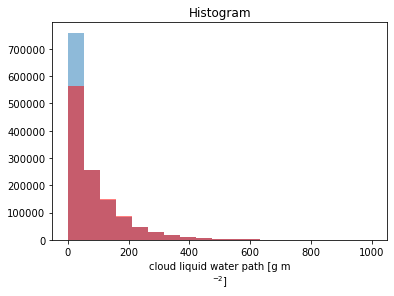

In [74]:
ds_all['cwp'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0, 1000, 20), alpha=.5, color='r')

In [75]:
ds_all['cwp_incld2'] = ds_all['cwp'] / ds_all['cl_clfr_max']

(array([ 3971.,  4354.,  4583.,  5029.,  5570.,  6060.,  6769.,  7362.,
         7912.,  8854.,  9790., 11199., 12267., 13444., 14884., 16678.,
        18533., 20113., 22241., 24524., 26970., 29554., 32722., 35633.,
        39228., 42320., 45561., 48886., 52411., 54853., 56032., 56727.,
        55760., 53818., 50145., 45799., 38993., 31434., 24875., 18885.,
        13950.,  9238.,  5909.,  3651.,  2188.,  1272.,   632.,   313.,
          103.]),
 array([1.00000000e+00, 1.15681872e+00, 1.33822954e+00, 1.54808898e+00,
        1.79085830e+00, 2.07169840e+00, 2.39657948e+00, 2.77240800e+00,
        3.20717346e+00, 3.71011828e+00, 4.29193426e+00, 4.96498988e+00,
        5.74359321e+00, 6.64429612e+00, 7.68624610e+00, 8.89159334e+00,
        1.02859616e+01, 1.18989929e+01, 1.37649776e+01, 1.59235837e+01,
        1.84206997e+01, 2.13094102e+01, 2.46511245e+01, 2.85168821e+01,
        3.29888630e+01, 3.81621341e+01, 4.41466709e+01, 5.10696951e+01,
        5.90783791e+01, 6.83429746e+01, 7.9060

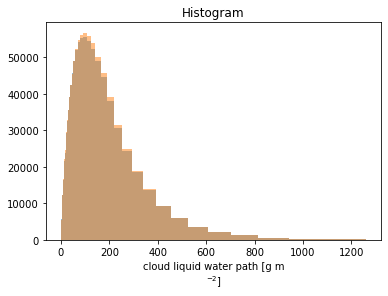

In [76]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

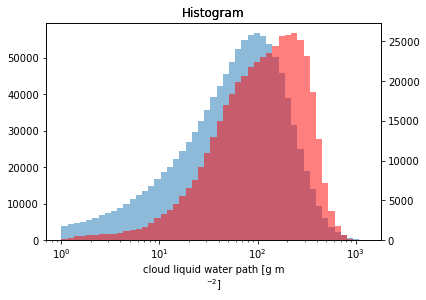

In [77]:
f, ax = plt.subplots(1)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)

ds_noresm['TGCLDCWP_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=0.5, ax=ax.twinx(), color='r')
plt.xscale('log')

#### *Mask values where cloud time max and cloud top cloud time is less than 10 percent 

(array([289475.,  18857.,  19275.,  21686.,      0.,  29491.,  34908.,
         51618.,  54147., 953375.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

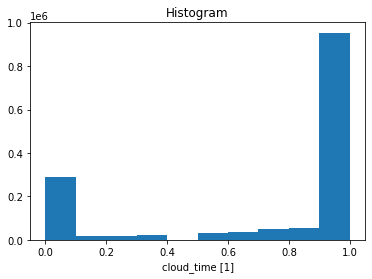

In [78]:
ds_all['cl_time_max'].plot.hist()

(array([ 15323.,  20049.,  22891.,      0.,  28704.,  31401.,      0.,
         41515.,  38483., 551999.]),
 array([0.125 , 0.2125, 0.3   , 0.3875, 0.475 , 0.5625, 0.65  , 0.7375,
        0.825 , 0.9125, 1.    ], dtype=float32),
 <BarContainer object of 10 artists>)

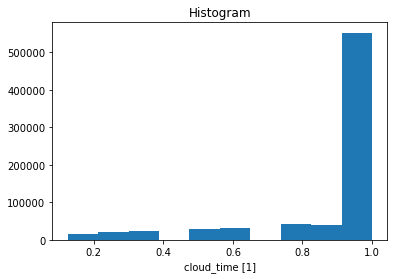

In [79]:
ds_all['cl_time_ct'].where(ds_all['cl_time_max']>.1).plot.hist()

In [80]:
number_before_mask = ds_all['ceff_ct_incld'].count()

In [81]:
ds_all = ds_all.where(ds_all['cl_time_max'] > .1)
ds_all = ds_all.where(ds_all['cl_time_ct'] > .1)

In [82]:
(ds_all['ceff_ct_incld'].count()-number_before_mask)/number_before_mask

<xarray.DataArray 'ceff_ct_incld' ()>
array(0.)
Coordinates:
    lev      float64 47.0
Attributes:
    long_name:    cloud droplet effective radius cloud top
    units:        um
    description:  cloud droplet effective radius cloud top

#### Shift timezone

In [83]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [84]:
ds_smll = ds_all[['mmrtrN100']]

In [85]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


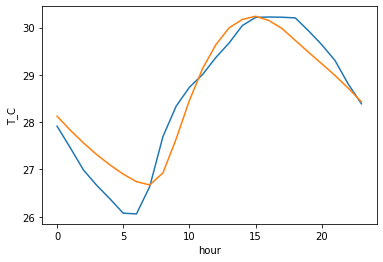

In [86]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


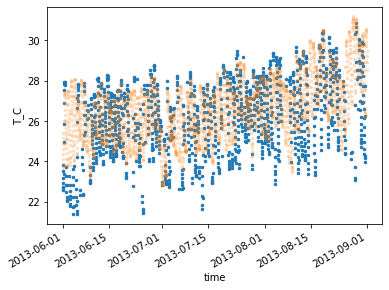

In [87]:

ds_all['T_C'].sel(time=slice('2013-06','2013-08')).sel(lat=lat_station, lon=lon_station, method='nearest').plot(label='full dataset',linewidth=0, marker='.', markersize=5)
ds_comb_station['T_C'].sel(time=slice('2013-06','2013-08')).plot(label='station dataset',linewidth=0,  marker='.', markersize=5, alpha=.2)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


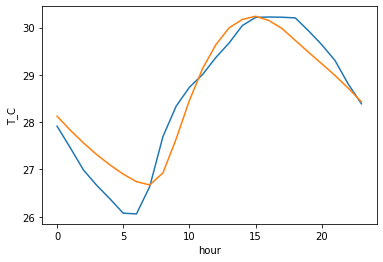

In [88]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [89]:
ds_comb_station = ds_comb_station.drop(['lon'])

In [90]:
varl_tmp = varl_st_echam + varl_st_computed

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [91]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

MYRC_gas
replacing MYRC_gas 
ISOP_gas
replacing ISOP_gas 
mmrtrN250
replacing mmrtrN250 
mmrtrN3
replacing mmrtrN3 
CARENE3_gas
replacing CARENE3_gas 
SO2_gas
replacing SO2_gas 
N200
replacing N200 
N100
replacing N100 
N500
replacing N500 
N50-500
replacing N50-500 
BPIN_gas
replacing BPIN_gas 
mmrtrN200
replacing mmrtrN200 
OA
replacing OA 
oh_con
replacing oh_con 
N100-500
replacing N100-500 
VBS0_gas
replacing VBS0_gas 
mmrtrN100
replacing mmrtrN100 
T_C
replacing T_C 
APIN_gas
replacing APIN_gas 
mmrtrN500
replacing mmrtrN500 
ccn02
replacing ccn02 
VBS10_gas
replacing VBS10_gas 
LIMON_gas
replacing LIMON_gas 
mmrtrN50
replacing mmrtrN50 
TBETAOCI_gas
replacing TBETAOCI_gas 
SABIN_gas
replacing SABIN_gas 
ccn10
replacing ccn10 
ORG_mass
replacing ORG_mass 
N200-500
replacing N200-500 
N50
replacing N50 


#### Replace all values by station values

In [92]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

(array([    0., 10493.,  6932.,  9970., 15791., 23288., 25859., 24874.,
        23330., 21510., 19756., 17776., 16043., 14279., 13098., 11945.,
        10881.,  9692.,  9102.,  8261.,  7403.,  6785.,  6204.,  5675.,
         5217.,  4713.,  4322.,  3978.,  3691.,  3411.,  3160.,  2976.,
         2804.,  2543.,  2419.,  2183.,  2031.,  1855.,  1783.,  1653.,
         1572.,  1455.,  1366.,  1296.,  1181.,  1108.,   963.,   915.,
          831.,   803.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 50 artists>)

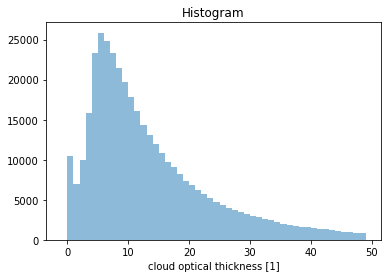

In [93]:
ds_all.where((ds_all['cwp_incld'] > 50) & (ds_all['cl_time_max'] > .1))['cod_incld'].plot.hist(bins=np.arange(-1, 50),
                                                                                               alpha=.5)

#### Final steps

In [94]:
dic_ds = dict()
dic_ds[case_name_echam] = ds_all

##### Rename vars

In [95]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

#### Save final csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
Masking with temp>-15!
cloud and resampled
cloud_avg median
station


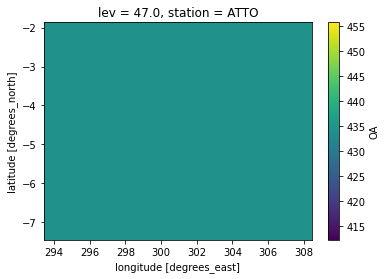

merge
df1


In [96]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims),

                                )

        df_mod = dic_df[case_name_echam]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

<AxesSubplot:xlabel='CWP', ylabel='COT'>

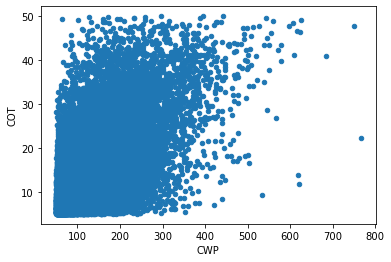

In [97]:
df_mod.plot.scatter(x='CWP', y='COT')

In [98]:
_fn_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

# EC-Earth

#### Names etc

In [99]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res = 'locations'
model_name = 'EC-Earth'
model_name_ec_earth = 'EC-Earth'

#### Input path:

In [100]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [101]:

cases_ec_earth = [case_name_ec_earth]

#### Filenames: 

In [102]:
fn_intermediate_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [103]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0')

#### Open pre calculated extracted fields

In [104]:
which = 'IFS'

In [105]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'

In [106]:
fl_open = []
# ds_list =[]
dic_ds = dict()

for which in ['IFS', 'IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


#### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [107]:
from bs_fdbck_clean.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
)

#### Fix units, calc cloud properties etc.

In [108]:
fn_intermediate_ec_earth

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0_intermediate.nc')

In [109]:
if not fn_intermediate_ec_earth.exists():

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds = rename_ifs_vars(_ds)

        _ds = fix_units_ec_earth(_ds)
        # _ds = calculate_incld_values_warmclouds(_ds)
        # _ds = extract_cloud_top(_ds)
        # _ds['lat'] = np.round(_ds['lat'], decimals=2)
        # _ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds = (
            _ds
            .assign(
                lat=lambda d: d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d: d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds

    ds = dic_ds['IFS']

    ds = calculate_incld_values_warmclouds(ds)

    ds = extract_cloud_top(ds)

    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev=model_lev_i)
        dic_ds[key] = ds_l

    ds_t = dic_ds['IFS_T']

    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U', 'V', 'temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']), ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()

#### Open file with fixed units and extracted cloud params:

In [110]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)

#### Fix units and decode time

In [111]:
ds_ifs['ttc'].attrs['units'] = 1

for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units'] == 1:
            ds_ifs[v].attrs['units'] = '1'
            print(f'{v} unit is 1')

ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cl_time_liq_norm sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cwp_incld g m-2
cloud_time_norm sec
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_cltop  um
cc_cltop 1
temp K


#### Overview plots

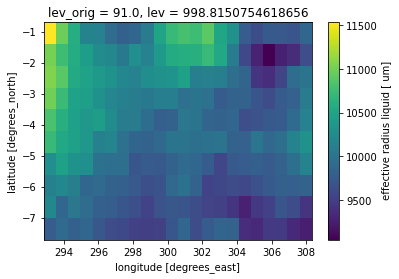

In [112]:
ds_ifs['re_liq_cltop'].count('time').plot()

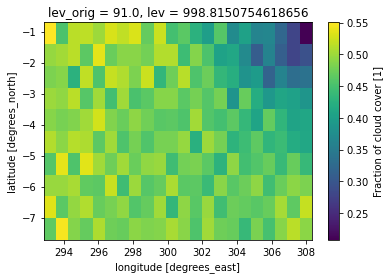

In [113]:
ds_ifs['cl_frac_where_cltime_pos'].mean('time').plot()

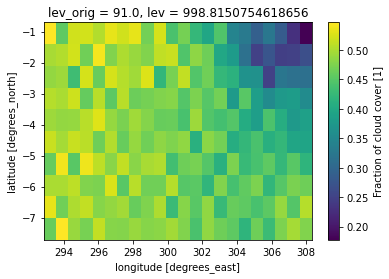

In [114]:
ds_ifs['cc_all'].mean('time').plot()

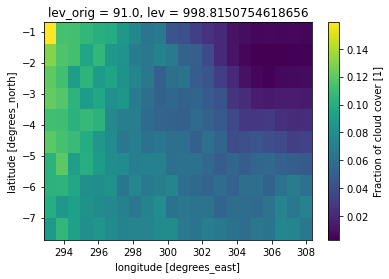

In [115]:
ds_ifs['cc'].mean('time').plot()

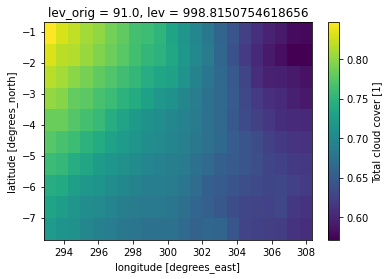

In [116]:
ds_ifs['ttc'].mean('time').plot()

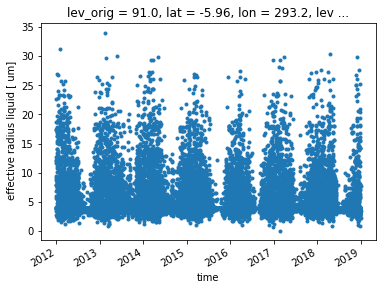

In [117]:
ds_ifs['re_liq'].isel(lat=2, lon=0).plot(x='time', linewidth=0, marker='.')

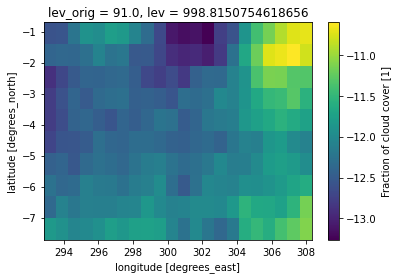

In [118]:
ds_ifs['argmax'].mean('time').plot()

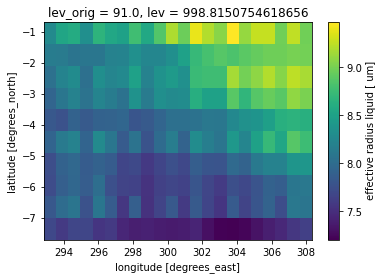

In [119]:
ds_ifs['re_liq_cltop'].mean('time').plot()

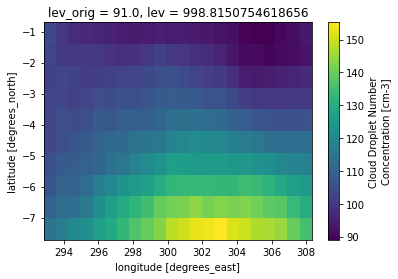

In [120]:
ds_ifs['cdnc_incld_cltop'].mean('time').plot()

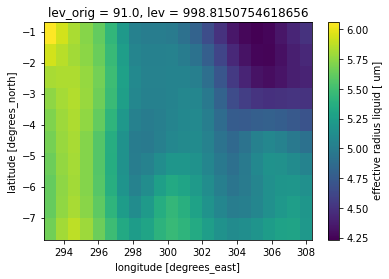

In [121]:
ds_ifs['re_liq'].mean('time').plot()

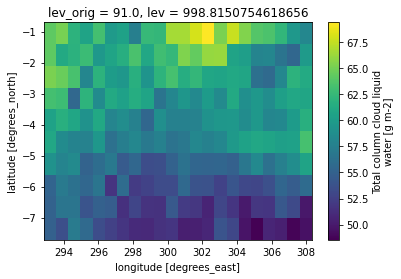

In [122]:
ds_ifs['tclw'].mean('time').plot()

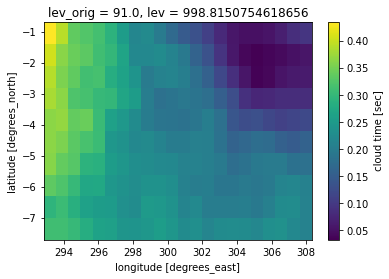

In [123]:
ds_ifs['cloud_time_norm'].mean('time').plot()

#### Masking and computing vars

##### *Mask values where cloud fraction is less than 10 percent

In [124]:
xr.set_options(keep_attrs=True)

(array([777749., 389259., 242567., 157146., 116609., 104515.,  92563.,
         79977.,  68542., 166519.]),
 array([0.203125 , 0.2828125, 0.3625   , 0.4421875, 0.521875 , 0.6015625,
        0.68125  , 0.7609375, 0.840625 , 0.9203125, 1.       ],
       dtype=float32),
 <BarContainer object of 10 artists>)

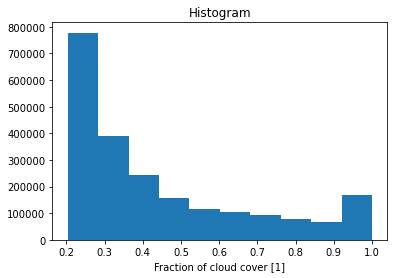

In [125]:
ds_ifs['cc_cltop'].plot.hist()

In [126]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop'] > .1)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,  56141., 144534., 315635.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.734

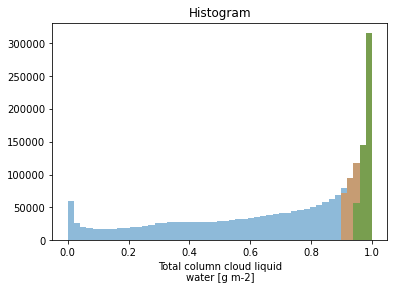

In [127]:
ds_ifs['liq_frac_cwp'].plot(bins=np.linspace(0,1), alpha=.5)
ds_ifs['liq_frac_cwp'].where(ds_ifs['liq_frac_cwp'] > .90).plot(bins=np.linspace(0,1), alpha=.5)
ds_ifs['liq_frac_cwp'].where(ds_ifs['liq_frac_cwp'] > .95).plot(bins=np.linspace(0,1), alpha=.5)

##### *Mask if ice water path more than 5% of total water path

In [128]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp'] > .95)

#### Shift timezone

In [129]:

with ProgressBar():
    ds_ifs.load()

if ds_ifs['time'].attrs['timezone'] == 'utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

shifted time by -4


#### Use station data computed before:

In [130]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [131]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

(array([   205.,  16672.,  80579.,  92973., 113683.,  70476.,  56250.,
         56070.,  27631.,   1771.]),
 array([290.6362 , 293.1899 , 295.74362, 298.2973 , 300.851  , 303.40472,
        305.95844, 308.51215, 311.06583, 313.61954, 316.17325],
       dtype=float32),
 <BarContainer object of 10 artists>)

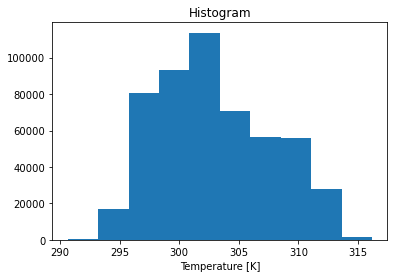

In [132]:
ds_ifs['temp'].plot()

##### Check time against station data

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


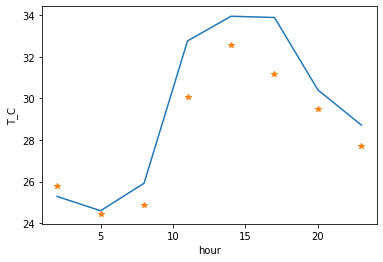

In [133]:
ds_ifs['hour'] = ds_ifs['time.hour']
_ds1 = ds_ifs.sel(time=slice('2012-07', '2012-08'))
_ds2 = ds_comb_station.sel(time=slice('2012-07', '2012-08'))
(_ds1['temp'] - 273.15).groupby(_ds1['hour']).mean().sel(lat=lat_station, lon=lon_station, method='nearest').plot()
_ds2['T_C'].groupby(_ds2['time.hour']).mean().plot(marker='*')

In [134]:
varl_station_ec_earth = [
    'CCN0.20',
    'CCN1.00',
    'M_BCACS',
    'M_BCAII',
    'M_BCAIS',
    'M_BCCOS',
    'M_DUACI',
    'M_DUACS',
    'M_DUCOI',
    'M_DUCOS',
    'M_POMACS',
    'M_POMAII',
    'M_POMAIS',
    'M_POMCOS',
    'M_SO4ACS',
    'M_SO4COS',
    'M_SO4NUS',
    'M_SOAACS',
    'M_SOAAII',
    'M_SOAAIS',
    'M_SOACOS',
    'M_SOANUS',
    'M_SSACS',
    'M_SSCOS',
    'OA',
    'SOA',
    'N_ACI',
    'N_ACS',
    'N_AII',
    'N_AIS',
    'N_COI',
    'N_COS',
    'N_NUS',
    'RDRY_ACS',
    'RDRY_AIS',
    'RDRY_COS',
    'RDRY_NUS',
    'RWET_ACI',
    'RWET_ACS',
    'RWET_AII',
    'RWET_AIS',
    'RWET_COI',
    'RWET_COS',
    'RWET_NUS',
    'emiisop',
    'emiterp',
    'T',
    'DDRY_NUS',
    'DDRY_AIS',
    'DDRY_ACS',
    'DDRY_COS',
    'DWET_AII',
    'DWET_ACI',
    'DWET_COI',
    'N50',
    'N70',
    'N100',
    'N150',
    'N200',
    'N500',
    'N50-500',
    'N70-500',
    'N100-500',
    'N150-500',
    'N200-500',
    'N50-500_STP',
    'N100-500_STP',
    'N200-500_STP',
    'N50_STP',
    'N100_STP',
    'N200_STP',
    'N500_STP',
    'OA_STP',
    'POM',
    'SOA',
    'SOA2',
    'T_C',

]

In [135]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [136]:
ds_smll = ds_ifs[['temp']]

In [137]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

emiterp
replacing emiterp 
OA_STP
replacing OA_STP 
M_SSACS
replacing M_SSACS 
POM
replacing POM 
RWET_AIS
replacing RWET_AIS 
M_SSCOS
replacing M_SSCOS 
N70
replacing N70 
N_ACI
replacing N_ACI 
RDRY_NUS
replacing RDRY_NUS 
RDRY_COS
replacing RDRY_COS 
M_SOACOS
replacing M_SOACOS 
N_ACS
replacing N_ACS 
T
replacing T 
M_BCAIS
replacing M_BCAIS 
N50-500
replacing N50-500 
M_SOAAII
replacing M_SOAAII 
N500_STP
replacing N500_STP 
N70-500
replacing N70-500 
M_SO4ACS
replacing M_SO4ACS 
M_BCAII
replacing M_BCAII 
M_BCACS
replacing M_BCACS 
RDRY_ACS
replacing RDRY_ACS 
emiisop
replacing emiisop 
M_BCCOS
replacing M_BCCOS 
M_POMACS
replacing M_POMACS 
M_SOAAIS
replacing M_SOAAIS 
N100-500
replacing N100-500 
N50-500_STP
replacing N50-500_STP 
M_DUCOI
replacing M_DUCOI 
N50_STP
replacing N50_STP 
N_COI
replacing N_COI 
N100-500_STP
replacing N100-500_STP 
M_SO4COS
replacing M_SO4COS 
CCN1.00
replacing CCN1.00 
RWET_COS
replacing RWET_COS 
N_AIS
replacing N_AIS 
CCN0.20
replacing CCN0.20 
DDR

##### Replace all values by station values

In [138]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

#### Final adjustments


In [139]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

##### Rename variables

In [140]:
# calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [141]:
ds = dic_ds[key]

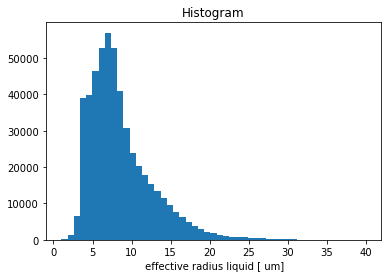

In [142]:
ds['r_eff'].plot(bins=np.linspace(1, 40));

In [143]:
ds['CWP_unweigth'] = ds['tclw']

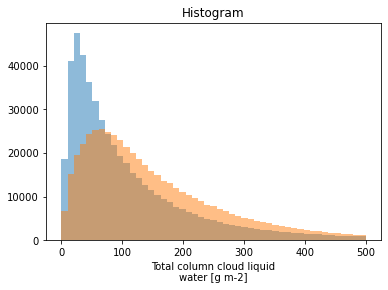

In [144]:
ds['CWP_unweigth'].plot(bins=np.linspace(0, 500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0, 500), alpha=.5);

##### Controle plots normalizing by cloud fraction

Text(0.5, 1.0, 'CWP divided by cloud fraction')

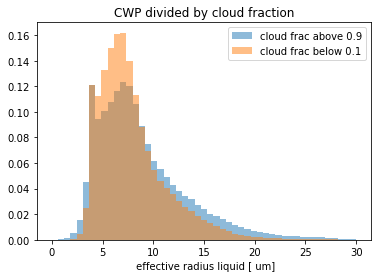

In [145]:
ds['r_eff'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc'] < .4).plot(bins=np.linspace(0, 30), alpha=.5, density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

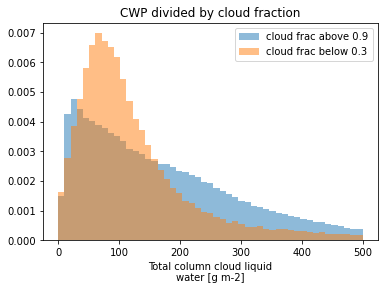

In [146]:
ds['CWP'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True, label='cloud frac below 0.3');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP not divided ')

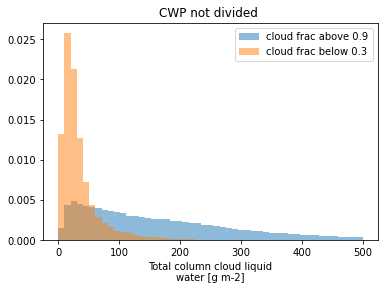

In [147]:
ds['CWP_unweigth'].where(ds['ttc'] > .9).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc'] < .3).plot(bins=np.linspace(0, 500), alpha=.5, density=True,
                                              label='cloud frac below 0.3');
plt.legend()
plt.title('CWP not divided ')

#### Final save csv

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


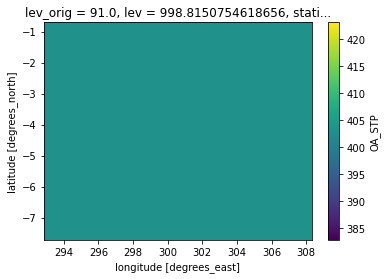

merge
df1


In [148]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas + '.csv')
    print(_fn_csv)

    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds,
                                select_hours_clouds=True,
                                summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim,
                                                       min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims
                                                       ),

                                )

        df_mod = dic_df[case_name_ec_earth]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

<AxesSubplot:ylabel='Frequency'>

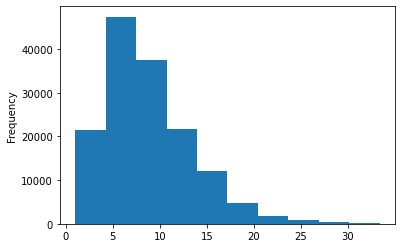

In [149]:
df_mod['r_eff'].plot.hist()

In [150]:
print('Done')

Done


# UKESM

In [151]:

case_name_ukesm = 'AEROCOMTRAJ'
case_name = case_name_ukesm
time_res = 'hour'
space_res = 'locations'
model_name_ukesm = 'UKESM'
model_name = model_name_ukesm

#### Input path

In [152]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm / case_name_ukesm

In [153]:

cases_ukesm = [case_name_ukesm]

#### Station variables  and others

In [154]:
varl_st_ukesm = [
'Mass_Conc_OM_NS',
'Mass_Conc_OM_KS',
'Mass_Conc_OM_KI',
'Mass_Conc_OM_AS',
'Mass_Conc_OM_CS',
'mmrtr_OM_NS',
'mmrtr_OM_KS',
'mmrtr_OM_KI',
'mmrtr_OM_AS',
'mmrtr_OM_CS',
'nconcNS',
'nconcKS',
'nconcKI',
'nconcAS',
'nconcCS',
'ddryNS',
'ddryKS',
'ddryKI',
'ddryAS',
'ddryCS',
'Temp',
    'N100',
    'N50',
    'N200',
    'N500',
    'OA',
    'N100_STP',
    'N50_STP',
    'N200_STP',
    'N500_STP',
    'N50-500_STP',
    'N100-500_STP',
    'N200-500_STP',
    'OA_STP',
    'T_C',
]

varl_cl_ukesm = [
    'Reff_2d_distrib_x_weight',
    'Reff_2d_x_weight_warm_cloud',
    'area_cloud_fraction_in_each_layer',
    'bulk_cloud_fraction_in_each_layer',
    'cloud_ice_content_after_ls_precip',
    'dry_rho',
    'frozen_cloud_fraction_in_each_layer',
    'liq_cloud_fraction_in_each_layer',
    'qcf',
    'qcl',
    'supercooled_liq_water_content',
    'weight_Reff_2d_distrib',
    'weight_Reff_2d',
    'cdnc_top_cloud_x_weight',
    'weight_of_cdnc_top_cloud',
    'ls_lwp',
    'ls_iwp',
    'conv_iwp',
    'conv_lwp',
    'rho',
    'layer_thickness',
    
]



#### Filenames:

In [155]:
fn_final_ukesm = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_ukesm_csv_stem = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

#### Open data area around station

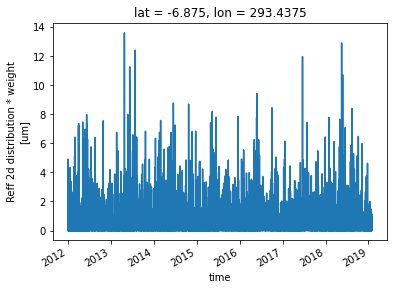

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Reff_2d_distrib_x_weight_concat_subs_293.0-308.0_-8.0--1.0.nc


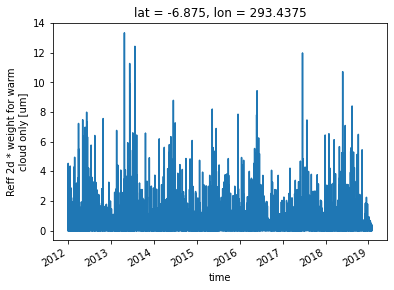

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Reff_2d_x_weight_warm_cloud_concat_subs_293.0-308.0_-8.0--1.0.nc


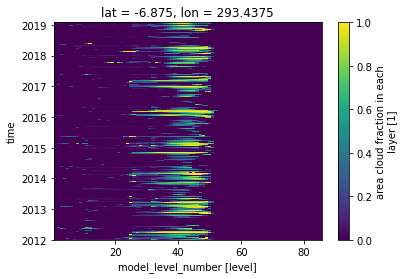

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_area_cloud_fraction_in_each_layer_concat_subs_293.0-308.0_-8.0--1.0.nc


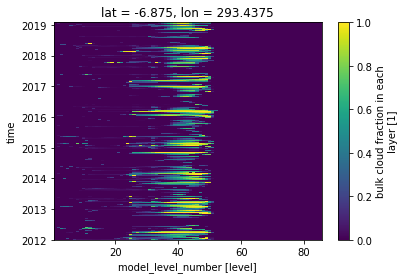

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_bulk_cloud_fraction_in_each_layer_concat_subs_293.0-308.0_-8.0--1.0.nc


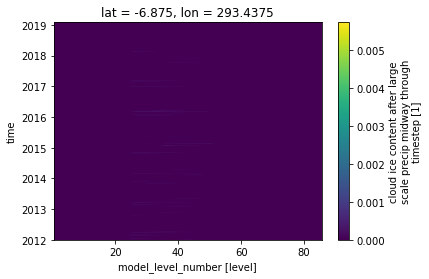

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_cloud_ice_content_after_ls_precip_concat_subs_293.0-308.0_-8.0--1.0.nc
Adding dry_rho to rho filelist: /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_dry_rho_concat_subs_293.0-308.0_-8.0--1.0.nc


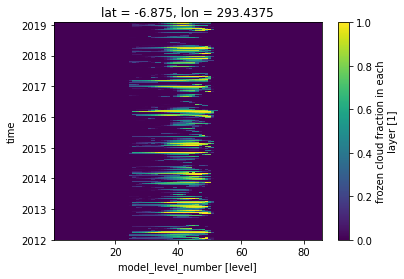

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_frozen_cloud_fraction_in_each_layer_concat_subs_293.0-308.0_-8.0--1.0.nc


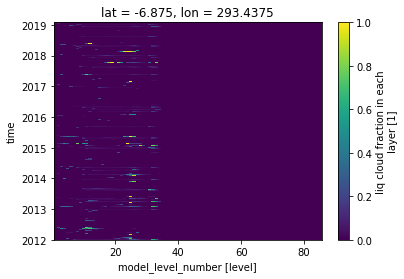

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_liq_cloud_fraction_in_each_layer_concat_subs_293.0-308.0_-8.0--1.0.nc


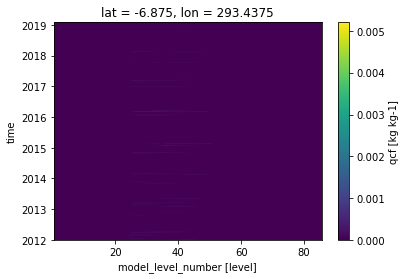

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_qcf_concat_subs_293.0-308.0_-8.0--1.0.nc


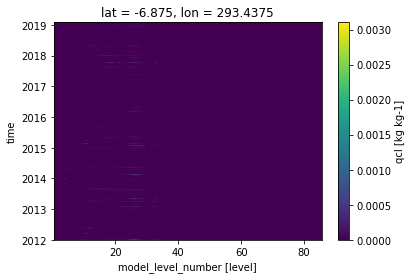

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_qcl_concat_subs_293.0-308.0_-8.0--1.0.nc


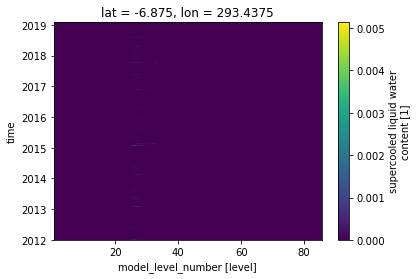

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_supercooled_liq_water_content_concat_subs_293.0-308.0_-8.0--1.0.nc


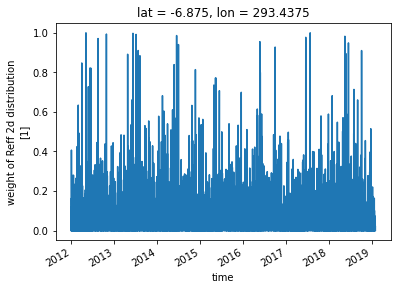

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_weight_Reff_2d_distrib_concat_subs_293.0-308.0_-8.0--1.0.nc


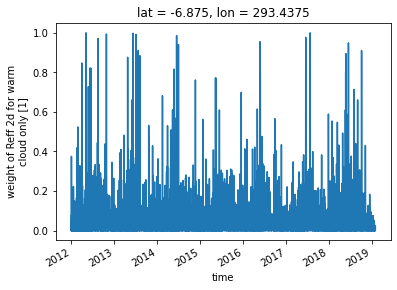

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_weight_Reff_2d_concat_subs_293.0-308.0_-8.0--1.0.nc


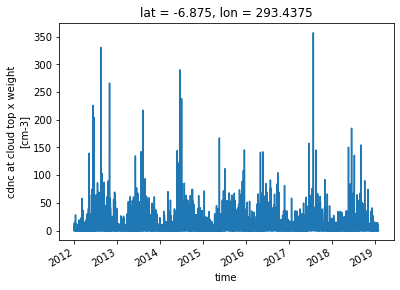

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_cdnc_top_cloud_x_weight_concat_subs_293.0-308.0_-8.0--1.0.nc


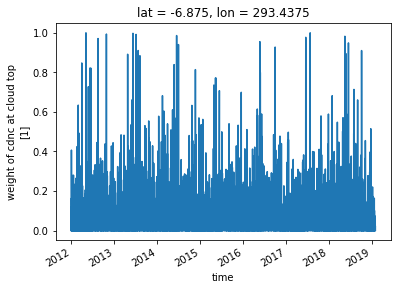

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_weight_of_cdnc_top_cloud_concat_subs_293.0-308.0_-8.0--1.0.nc


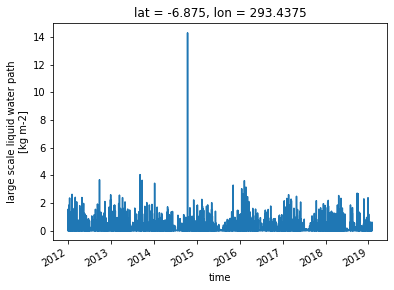

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ls_lwp_concat_subs_293.0-308.0_-8.0--1.0.nc


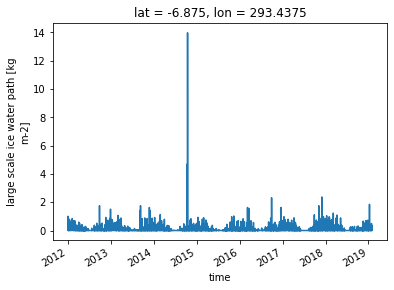

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ls_iwp_concat_subs_293.0-308.0_-8.0--1.0.nc


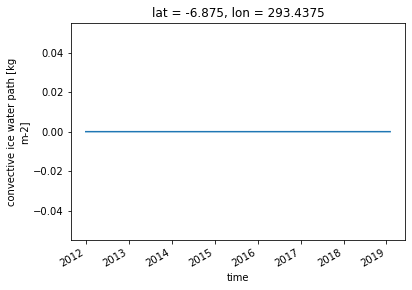

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_conv_iwp_concat_subs_293.0-308.0_-8.0--1.0.nc


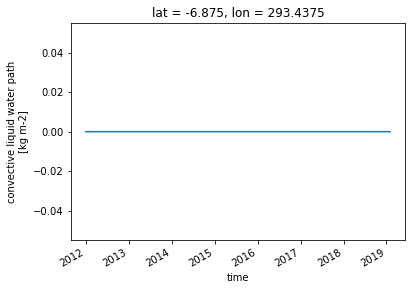

Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_conv_lwp_concat_subs_293.0-308.0_-8.0--1.0.nc
Adding rho to rho filelist: /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_rho_concat_subs_293.0-308.0_-8.0--1.0.nc
ups, coult not plot
Opening /proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_layer_thickness_concat_subs_293.0-308.0_-8.0--1.0.nc
Mass_Conc_OM_NS not found
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Mass_Conc_OM_NS_concat_subs_293.0-308.0_-8.0--1.0.nc
Mass_Conc_OM_KS not found
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_Mass_Conc_OM_KS_concat_sub

In [156]:
fl_open = []
fl_rho = []

for v in varl_cl_ukesm + varl_st_ukesm:
    fn = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    #print(fn)
    if fn.exists():
        if (v=='dry_rho') or (v=='rho'):
            fl_rho.append(fn)
            print(f'Adding {v} to rho filelist: {fn}')
            continue
            
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        try:
            _ds[v].isel(lat=0,lon=0).plot()
            plt.show()
        except:
            print('ups, coult not plot')
        print(f'Opening {fn}')
    else:
        print(f'{v} not found')
        print(fn)

#### Open files, decode time etc

In [157]:
fl_open = list(set(fl_open))

#### Some timestamps have small errors in them (20 min off the hour), so we round some files:


In [158]:


ls_ds = []
for f in fl_open:
    _ds = xr.open_dataset(f, decode_times=False)
    if 'time' in _ds.coords:
        if 'hours since' in _ds['time'].units:
            _ds['time'] = np.floor(_ds['time'])
            _ds = xr.decode_cf(_ds)
    ls_ds.append(_ds)

ds_all = xr.merge(ls_ds)

In [159]:
ls_ds_rho = []
for f in fl_rho:
    _ds = xr.open_dataset(f, decode_times=False)
    if 'time' in _ds.coords:
        if 'hours since' in _ds['time'].units:
            _ds['time'] = np.floor(_ds['time'])
            _ds = xr.decode_cf(_ds)
    ls_ds_rho.append(_ds)

ds_rho = xr.merge(ls_ds_rho)

### Somehow the rho has different level than the other, but this is due to it being at the grid box interface, not mid point, so we can ignore it

In [160]:
for v in ['rho','dry_rho']:
    ds_all[v] = ds_rho[v]

In [161]:
fn_final_ukesm

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0.nc')

### layer thickness has the wrong vertical coordinate name:

In [162]:
ds_all['layer'] = ds_all['layer'].swap_dims({'lev':'model_level'})

In [163]:
ds_all['ls_lwp'].quantile(.95)*1000

<xarray.DataArray 'ls_lwp' ()>
array(274.4140625)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            kg m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [164]:
from bs_fdbck_clean.util.BSOA_datamanip.ukesm import extract_2D_cloud_time_ukesm, change_units_and_compute_vars_ukesm

In [165]:
if True:#not fn_final_ukesm.exists():
    #ds_all = xr.open_mfdataset(fl_open, decode_cf=False)
    # ds_iso = xr.open_dataset(fl_open[21])
    # ds = xr.merge([ds_iso,ds])
    #ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)

    # ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_ukesm(ds_all)

    # ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    #ds_all = ds_all.drop(['hyai', 'hybi', 'hyam', 'hybm']).squeeze()
    if 'model_level' in ds_all.coords:
        ds_all = ds_all.isel(model_level=(-1-model_lev_i_ukesm))

    # ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_smr, lat = lat_smr)

    ds_all = change_units_and_compute_vars_ukesm(ds_all)

    
    
    
    delayed_obj = ds_all.to_netcdf(fn_final_ukesm, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

converting units lwp
converting units iwp
['cdnc_top_cloud_x_weight', 'ls_iwp', 'Reff_2d_distrib_x_weight', 'bulk_cloud_fraction_in_each_layer', 'level_height', 'sigma', 'conv_lwp', 'area_cloud_fraction_in_each_layer', 'layer', 'weight_of_cdnc_top_cloud', 'supercooled_liq_water_content', 'qcf', 'ls_lwp', 'Reff_2d_x_weight_warm_cloud', 'weight_Reff_2d', 'liq_cloud_fraction_in_each_layer', 'conv_iwp', 't_at_eot', 'qcl', 'frozen_cloud_fraction_in_each_layer', 'weight_Reff_2d_distrib', 'cloud_ice_content_after_ls_precip', 'rho', 'dry_rho', 'r_eff', 'r_eff2', 'max_cloud_cover', 'max_cloud_fraction', 'lwp', 'iwp', 'lwp_incld', 'computed_lwp_sum', 'computed_lwp_sum_incld', 'computed_iwp_sum', 'computed_iwp_sum_incld', 'liq_frac_cwp', 'OA']
{'cdnc_top_cloud_x_weight': 'cdnc_top_cloud_x_weight', 'ls_iwp': 'ls_iwp', 'Reff_2d_distrib_x_weight': 'Reff_2d_distrib_x_weight', 'bulk_cloud_fraction_in_each_layer': 'bulk_cloud_fraction_in_each_layer', 'conv_lwp': 'conv_lwp', 'area_cloud_fraction_in_each

In [166]:
ds_all['lwp'].quantile(.95)

<xarray.DataArray 'lwp' ()>
array(274.4140625)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [167]:
ds_all = xr.open_dataset(fn_final_ukesm)
ds_all['time'].attrs['timezone'] = 'utc'


#### Add variables from station data to imitate using station measurements

In [168]:
df_comb_station = dic_df_station[model_name_ukesm][case_name_ukesm]

In [169]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

In [170]:
ds_comb_station

<xarray.Dataset>
Dimensions:                        (time: 21440, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2011-12-31T19:00:00 ...
  * station                        (station) <U4 'ATTO'
Data variables: (12/48)
    lev                            (time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    Mass_Conc_OM_AS                (time) float64 3.031 3.865 ... 2.636 3.117
    Mass_Conc_OM_CS                (time) float64 4.717e-11 ... 2.972e-11
    Mass_Conc_OM_KI                (time) float64 0.0005246 ... 9.944e-05
    Mass_Conc_OM_KS                (time) float64 0.5531 0.1098 ... 0.02995
    Mass_Conc_OM_NS                (time) float64 9.943e-08 ... 3.192e-08
    ...                             ...
    N200_STP                       (time) float64 581.4 696.9 ... 506.6 574.2
    N50_STP                        (time) float64 1.76e+03 ... 1.324e+03
    N500_STP                       (time) float64 8.473 7.23 ... 5.886 4.584
    N50-500_STP                    (time) float64 1.751e+03 ... 1.319e+03
    N100-500_STP                   (time) float64 1.304e+03 ... 1.142e+03
    N200-500_STP                   (time) float64 572.9 689.7 ... 500.7 569.7

In [171]:
ds_all['lwp'].quantile(.95)

<xarray.DataArray 'lwp' ()>
array(274.4140625)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [172]:
ds_all['lwp_incld'].quantile(.95)

<xarray.DataArray 'lwp_incld' ()>
array(622.43390808)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

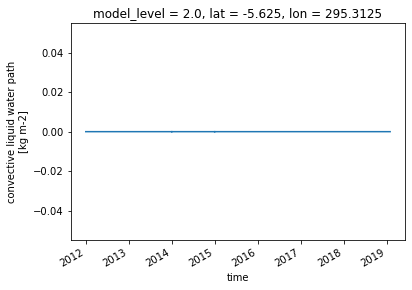

In [173]:
ds_all['conv_lwp'].isel(lat=1, lon=1).plot()

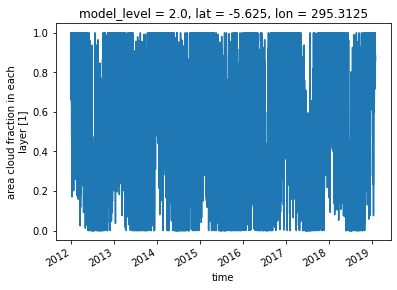

In [174]:
ds_all['max_cloud_cover'].isel(lat=1, lon=1).plot()

#### Finally produce daily median dataset:

In [175]:
dic_ds = dict()
dic_ds[case_name_ukesm] = ds_all

##### Controle plots

In [176]:
ds_all['lwp_incld'].where(ds_all['max_cloud_cover']>.1).quantile(0.90)

<xarray.DataArray 'lwp_incld' ()>
array(233.64812469)
Coordinates:
    quantile  float64 0.9
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [177]:
ds_all['lwp'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp' ()>
array(326.66015625)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [178]:
ds_all['lwp_incld'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp_incld' ()>
array(581.50693359)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

(array([511460.,  52089.,  33583.,  23114.,  16544.,  12043.,   9297.,
          7106.,   6082.,   5124.,   4557.,   4084.,   3540.,   3175.,
          2872.,   2709.,   2422.,   2211.,   2136.]),
 array([  0.        ,  21.05263158,  42.10526316,  63.15789474,
         84.21052632, 105.26315789, 126.31578947, 147.36842105,
        168.42105263, 189.47368421, 210.52631579, 231.57894737,
        252.63157895, 273.68421053, 294.73684211, 315.78947368,
        336.84210526, 357.89473684, 378.94736842, 400.        ]),
 <BarContainer object of 19 artists>)

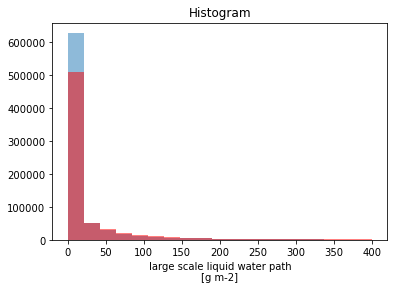

In [179]:
ds_all['lwp'].plot(bins=np.linspace(0, 400, 20), alpha=.5, )

ds_all['lwp_incld'].plot(bins=np.linspace(0, 400, 20), alpha=.5, color='r')

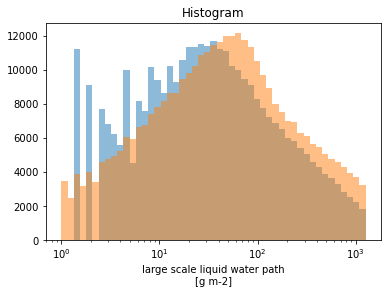

In [180]:
f, ax = plt.subplots(1)
ds_all['lwp'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
ds_all['lwp_incld'].plot.hist(bins=np.logspace(0, 3.1), alpha=.5, ax=ax)
plt.xscale('log')

#### Masking and computing vars

#### *Mask where cloud fraction is above 10 percent 

(array([ 53511.,  65837.,  60966.,  58724.,  56273.,  55078.,  53566.,
         54070.,  58936., 170083.]),
 array([0.10009766, 0.19008788, 0.2800781 , 0.37006837, 0.4600586 ,
        0.5500488 , 0.6400391 , 0.7300293 , 0.82001954, 0.91000974,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

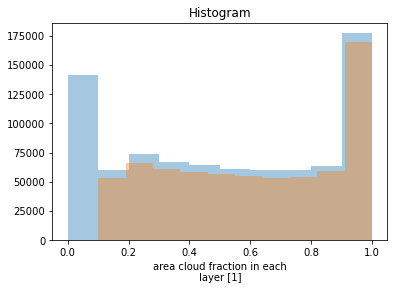

In [181]:
ds_all['max_cloud_cover'].plot.hist(alpha=.4)
ds_all['max_cloud_cover'].where(ds_all['max_cloud_cover']>0.1).plot.hist(alpha=.4)

##### *Mask if ice water path more than 5% of total water path

In [182]:
ds_all = ds_all.where(ds_all['liq_frac_cwp'] > .95)

(array([17305., 22814., 14620., 10215.,  7741.,  6520.,  5946.,  5825.,
         6793., 19429.]),
 array([0.10009766, 0.19008788, 0.2800781 , 0.37006837, 0.4600586 ,
        0.5500488 , 0.6400391 , 0.7300293 , 0.82001954, 0.91000974,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

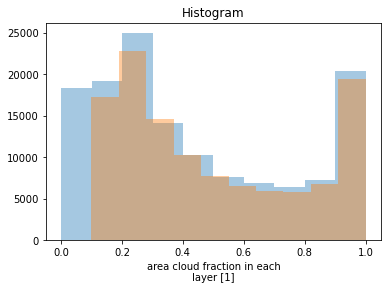

In [183]:
ds_all['max_cloud_cover'].plot.hist(alpha=.4)
ds_all['max_cloud_cover'].where(ds_all['max_cloud_cover']>0.1).plot.hist(alpha=.4)

In [184]:
ds_all = ds_all.where(ds_all['max_cloud_cover']>0.1)

### *Mask where cloud top weight less than 10 percent: 

(array([7430., 6506., 5515., 4692., 3840., 2927., 2321., 1886., 1517.,
        1204., 1079.,  907.,  781.,  682.,  620.,  614.,  539.,  461.,
         422.,  385.,  395.,  355.,  334.,  303.,  286.,  306.,  254.,
         243.,  235.,  218.,  212.,  195.,  186.,  181.,  181.,  158.,
         163.,  171.,  167.,  139.,  161.,  127.,  116.,  123.,  122.,
         108.,  111.,  125.,  127.]),
 array([  0.        ,  16.32653061,  32.65306122,  48.97959184,
         65.30612245,  81.63265306,  97.95918367, 114.28571429,
        130.6122449 , 146.93877551, 163.26530612, 179.59183673,
        195.91836735, 212.24489796, 228.57142857, 244.89795918,
        261.2244898 , 277.55102041, 293.87755102, 310.20408163,
        326.53061224, 342.85714286, 359.18367347, 375.51020408,
        391.83673469, 408.16326531, 424.48979592, 440.81632653,
        457.14285714, 473.46938776, 489.79591837, 506.12244898,
        522.44897959, 538.7755102 , 555.10204082, 571.42857143,
        587.75510204, 604.08163

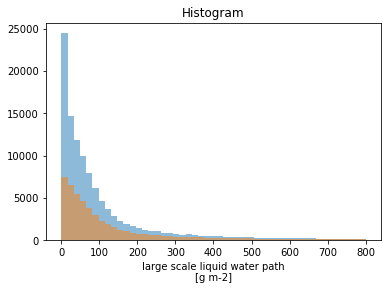

In [185]:
ds_all['lwp_incld'].plot.hist(bins=np.linspace(0,800), alpha =.5)

ds_all['lwp_incld'].where(ds_all['weight_of_cdnc_top_cloud']>0.1).plot.hist(bins=np.linspace(0,800), alpha =.5)

In [186]:
ds_all = ds_all.where(ds_all['weight_Reff_2d_distrib']>0.1)

#### UKESM Shift time step to start of period to be consistent with measurements and other models
Note that station data is already corrected in the same way. 

In [187]:
if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=1)
    #ds_all['time'].attrs['timezone'] = 'utc+2'
    ds_all['time'].attrs['timezone'] = 'utc'
    
    print('shifted time by -1 for UKESM')

shifted time by -1 for UKESM


#### Shift timezone

In [188]:

with ProgressBar():
    ds_all.load()

if ds_all['time'].attrs['timezone'] == 'utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    # dic_ds[k] = _ds

shifted time by -4


#### Broadcast computed variables so that only station value is in the gridcells. 

In [189]:
ds_all

<xarray.Dataset>
Dimensions:                              (time: 20704, lat: 5, lon: 8)
Coordinates:
    model_level                          float32 2.0
  * time                                 (time) datetime64[ns] 2011-12-31T19:...
  * lat                                  (lat) float32 -6.875 -5.625 ... -1.875
  * lon                                  (lon) float32 293.4 295.3 ... 306.6
Data variables: (12/37)
    cdnc_top_cloud_x_weight              (time, lat, lon) float32 nan ... nan
    ls_iwp                               (time, lat, lon) float32 nan ... nan
    Reff_2d_distrib_x_weight             (time, lat, lon) float32 nan ... nan
    bulk_cloud_fraction_in_each_layer    (time, lat, lon) float32 nan ... nan
    level_height                         (time, lat, lon) float64 nan ... nan
    sigma                                (time, lat, lon) float64 nan ... nan
    ...                                   ...
    computed_lwp_sum                     (time, lat, lon) float32 nan ... nan
    computed_lwp_sum_incld               (time, lat, lon) float32 nan ... nan
    computed_iwp_sum                     (time, lat, lon) float32 nan ... nan
    computed_iwp_sum_incld               (time, lat, lon) float32 nan ... nan
    liq_frac_cwp                         (time, lat, lon) float32 nan ... nan
    OA                                   (time, lat, lon) float64 nan ... nan
Attributes:
    conventions:  CF-1.7
    source:       Met Office Unified Model
    version:      11.1
    model:        UKESM1.0
    realm:        atmosphere
    institution:  CEMPS, University of Exeter
    project:      AeroCom
    experiment:   GCMTraj
    history:      Mon Mar 20 09:49:08 2023: ncrcat -O /proj/bolinc/users/x_sa...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [190]:
ds_all['lwp'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp' ()>
array(455.078125)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [191]:
ds_all['lwp_incld'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp_incld' ()>
array(1826.55917358)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [192]:
ds_smll = ds_all[['qcf']]

In [193]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=[select_station])

##### Check time by comparing to station dataset

In [194]:
lon_station

300.991

In [195]:
ds_comb_station

<xarray.Dataset>
Dimensions:                        (time: 21440, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2011-12-31T19:00:00 ...
  * station                        (station) <U4 'ATTO'
Data variables: (12/48)
    lev                            (time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    Mass_Conc_OM_AS                (time) float64 3.031 3.865 ... 2.636 3.117
    Mass_Conc_OM_CS                (time) float64 4.717e-11 ... 2.972e-11
    Mass_Conc_OM_KI                (time) float64 0.0005246 ... 9.944e-05
    Mass_Conc_OM_KS                (time) float64 0.5531 0.1098 ... 0.02995
    Mass_Conc_OM_NS                (time) float64 9.943e-08 ... 3.192e-08
    ...                             ...
    N200_STP                       (time) float64 581.4 696.9 ... 506.6 574.2
    N50_STP                        (time) float64 1.76e+03 ... 1.324e+03
    N500_STP                       (time) float64 8.473 7.23 ... 5.886 4.584
    N50-500_STP                    (time) float64 1.751e+03 ... 1.319e+03
    N100-500_STP                   (time) float64 1.304e+03 ... 1.142e+03
    N200-500_STP                   (time) float64 572.9 689.7 ... 500.7 569.7

In [196]:
ds_all

<xarray.Dataset>
Dimensions:                              (time: 20704, lat: 5, lon: 8)
Coordinates:
    model_level                          float32 2.0
  * time                                 (time) datetime64[ns] 2011-12-31T19:...
  * lat                                  (lat) float32 -6.875 -5.625 ... -1.875
  * lon                                  (lon) float32 293.4 295.3 ... 306.6
Data variables: (12/37)
    cdnc_top_cloud_x_weight              (time, lat, lon) float32 nan ... nan
    ls_iwp                               (time, lat, lon) float32 nan ... nan
    Reff_2d_distrib_x_weight             (time, lat, lon) float32 nan ... nan
    bulk_cloud_fraction_in_each_layer    (time, lat, lon) float32 nan ... nan
    level_height                         (time, lat, lon) float64 nan ... nan
    sigma                                (time, lat, lon) float64 nan ... nan
    ...                                   ...
    computed_lwp_sum                     (time, lat, lon) float32 nan ... nan
    computed_lwp_sum_incld               (time, lat, lon) float32 nan ... nan
    computed_iwp_sum                     (time, lat, lon) float32 nan ... nan
    computed_iwp_sum_incld               (time, lat, lon) float32 nan ... nan
    liq_frac_cwp                         (time, lat, lon) float32 nan ... nan
    OA                                   (time, lat, lon) float64 nan ... nan
Attributes:
    conventions:  CF-1.7
    source:       Met Office Unified Model
    version:      11.1
    model:        UKESM1.0
    realm:        atmosphere
    institution:  CEMPS, University of Exeter
    project:      AeroCom
    experiment:   GCMTraj
    history:      Mon Mar 20 09:49:08 2023: ncrcat -O /proj/bolinc/users/x_sa...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [197]:
_ds = xr.merge([ds_all[['Temp']].sel(lat=lat_station, lon=lon_station, method='nearest'), ds_comb_station[['T_C']]])
_ds['notnull'] = (_ds['Temp'].notnull()) & (_ds['T_C'].notnull())

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


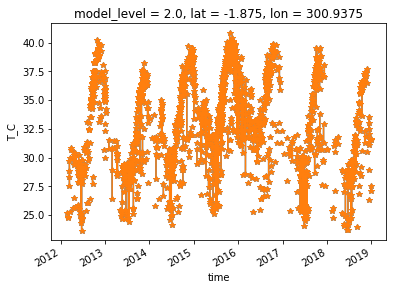

In [198]:
(_ds['Temp']-273.15).where(_ds['notnull']).plot(marker='*')
(_ds['T_C']).where(_ds['notnull']).plot(marker='*')

In [199]:
_da = ds_comb_station['T_C'].sel(time=slice('2013','2018'))

In [200]:
_da2 = (ds_all['Temp']-273.15).sel(time=slice('2013','2018')).sel(lat=lat_station, lon=lon_station, method='nearest')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


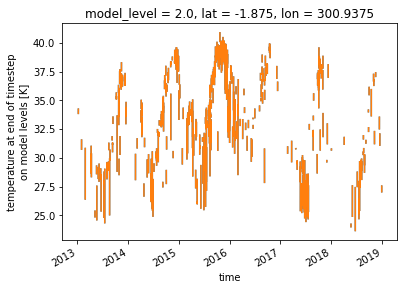

In [201]:
_da.where(_da2.notnull()).plot()
_da2.plot()

<AxesSubplot:xlabel='time'>

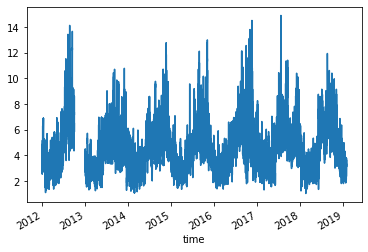

In [202]:
df_comb_station['OA_STP'].plot()

In [203]:
varl_st_ukesm

['Mass_Conc_OM_NS',
 'Mass_Conc_OM_KS',
 'Mass_Conc_OM_KI',
 'Mass_Conc_OM_AS',
 'Mass_Conc_OM_CS',
 'mmrtr_OM_NS',
 'mmrtr_OM_KS',
 'mmrtr_OM_KI',
 'mmrtr_OM_AS',
 'mmrtr_OM_CS',
 'nconcNS',
 'nconcKS',
 'nconcKI',
 'nconcAS',
 'nconcCS',
 'ddryNS',
 'ddryKS',
 'ddryKI',
 'ddryAS',
 'ddryCS',
 'Temp',
 'N100',
 'N50',
 'N200',
 'N500',
 'OA',
 'N100_STP',
 'N50_STP',
 'N200_STP',
 'N500_STP',
 'N50-500_STP',
 'N100-500_STP',
 'N200-500_STP',
 'OA_STP',
 'T_C']

In [204]:
varl_tmp = varl_st_ukesm

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [205]:
varl_tmp

['mmrtr_OM_CS',
 'Mass_Conc_OM_NS',
 'OA_STP',
 'mmrtr_OM_NS',
 'ddryKI',
 'ddryAS',
 'N500_STP',
 'nconcCS',
 'ddryNS',
 'mmrtr_OM_AS',
 'N50-500_STP',
 'ddryKS',
 'N50_STP',
 'N100-500_STP',
 'nconcKS',
 'Mass_Conc_OM_AS',
 'T_C',
 'mmrtr_OM_KI',
 'nconcKI',
 'nconcNS',
 'Mass_Conc_OM_KS',
 'nconcAS',
 'ddryCS',
 'N200-500_STP',
 'Mass_Conc_OM_KI',
 'Mass_Conc_OM_CS',
 'N100_STP',
 'N200_STP',
 'mmrtr_OM_KS']

In [206]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds=False)

mmrtr_OM_CS
replacing mmrtr_OM_CS 
Mass_Conc_OM_NS
replacing Mass_Conc_OM_NS 
OA_STP
replacing OA_STP 
mmrtr_OM_NS
replacing mmrtr_OM_NS 
ddryKI
replacing ddryKI 
ddryAS
replacing ddryAS 
N500_STP
replacing N500_STP 
nconcCS
replacing nconcCS 
ddryNS
replacing ddryNS 
mmrtr_OM_AS
replacing mmrtr_OM_AS 
N50-500_STP
replacing N50-500_STP 
ddryKS
replacing ddryKS 
N50_STP
replacing N50_STP 
N100-500_STP
replacing N100-500_STP 
nconcKS
replacing nconcKS 
Mass_Conc_OM_AS
replacing Mass_Conc_OM_AS 
T_C
replacing T_C 
mmrtr_OM_KI
replacing mmrtr_OM_KI 
nconcKI
replacing nconcKI 
nconcNS
replacing nconcNS 
Mass_Conc_OM_KS
replacing Mass_Conc_OM_KS 
nconcAS
replacing nconcAS 
ddryCS
replacing ddryCS 
N200-500_STP
replacing N200-500_STP 
Mass_Conc_OM_KI
replacing Mass_Conc_OM_KI 
Mass_Conc_OM_CS
replacing Mass_Conc_OM_CS 
N100_STP
replacing N100_STP 
N200_STP
replacing N200_STP 
mmrtr_OM_KS
replacing mmrtr_OM_KS 


#### Replace all values by station values

In [207]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

#### Final steps

In [208]:
dic_ds = dict()
dic_ds[case_name_ukesm] = ds_all

##### Rename vars

In [209]:
from bs_fdbck_clean.util.BSOA_datamanip import rn_dic_ukesm_cloud

In [210]:
rn_dic_ukesm_cloud

{'lwp_incld': 'CWP', 'r_eff': 'r_eff'}

In [211]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ukesm_cloud)

#### Save final csv

In [212]:
dic_ds[key]['CWP'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'CWP' ()>
array(1826.55917358)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [213]:
ds_all['lwp_incld'].where(ds_all['max_cloud_cover']>.10).quantile(0.95)

<xarray.DataArray 'lwp_incld' ()>
array(1826.55917358)
Coordinates:
    quantile  float64 0.95
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
hours
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP and 800>CWP!
Masking with r_eff>1!
cloud and resampled
cloud_avg median
station


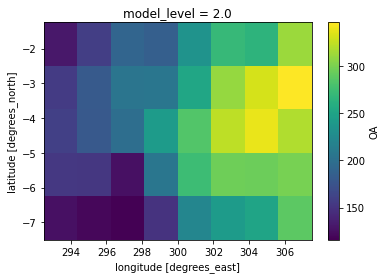

merge
df1


In [214]:
for seas in calc_seasons:
    _fn_csv = fn_final_ukesm_csv_stem.parent / (fn_final_ukesm_csv_stem.stem + seas + '.csv')
    print(_fn_csv)
    if True:  # not _fn_csv.exists():
        # for key in dic_ds.keys():

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],
                                mask_cloud_values=True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                # kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds=dict(min_reff=r_eff_lim, min_cwp=cld_water_path_above,
                                                       tau_bounds=tau_lims),

                                )

        df_mod = dic_df[case_name_ukesm]
        # with ProgressBar():
        # df_mod = df_mod.dropna()
        df_mod.to_csv(_fn_csv)

In [215]:
pd.read_csv('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv',index_col=0)

,lat,lon,station,liq_frac_cwp,CWP,r_eff,month,ismonth1,ismonth2,ismonth3,...,N50_STP,OA_STP,N100-500_STP,N200-500_STP,N500_STP,T_C,N100_STP,N200_STP,OA,year
time,,,,,,,,,,,,,,,,,,,,,
2011-12-31,-6.875,293.4375,ATTO,NaN,NaN,NaN,12.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
2011-12-31,-6.875,295.3125,ATTO,NaN,NaN,NaN,12.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
2011-12-31,-6.875,297.1875,ATTO,NaN,NaN,NaN,12.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
2011-12-31,-6.875,299.0625,ATTO,NaN,NaN,NaN,12.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
2011-12-31,-6.875,300.9375,ATTO,NaN,NaN,NaN,12.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31,-1.875,299.0625,ATTO,NaN,NaN,NaN,1.0,1.0,0.0,0.0,...,1323.650244,3.414563,1097.057606,500.749829,4.86878,33.546295,1102.943267,506.63549,NaN,2019
2019-01-31,-1.875,300.9375,ATTO,NaN,NaN,NaN,1.0,1.0,0.0,0.0,...,1323.650244,3.414563,1097.057606,500.749829,4.86878,33.546295,1102.943267,506.63549,NaN,2019
2019-01-31,-1.875,302.8125,ATTO,NaN,NaN,NaN,1.0,1.0,0.0,0.0,...,1323.650244,3.414563,1097.057606,500.749829,4.86878,33.546295,1102.943267,506.63549,NaN,2019


In [216]:
_ds = dic_ds['AEROCOMTRAJ']
_ds = _ds.where(_ds['max_cloud_cover']>0.1)

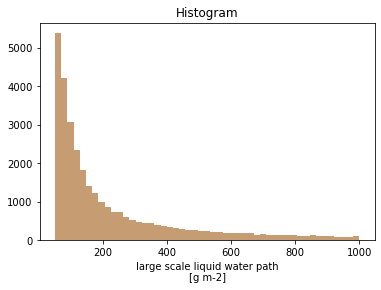

In [217]:
#_ds['computed_lwp_sum'].plot(bins=np.linspace(50,1000), alpha=.5);

#(_ds['computed_lwp_sum']/_ds['max_cloud_cover']).plot(bins=np.linspace(50,1000), alpha=.5);

#_ds['lwp'].plot(bins=np.linspace(50,1000), alpha=.5);


(_ds['lwp']/_ds['max_cloud_cover']).plot(bins=np.linspace(50,1000), alpha=.5);



_ds['CWP'].plot(bins=np.linspace(50,1000), alpha=.5);

In [218]:
df_mod['CWP'].quantile(.95)

605.6798

(array([5370., 4207., 3082., 2358., 1831., 1416., 1218.,  995.,  876.,
         721.,  734.,  612.,  532.,  477.,  448.,  435.,  390.,  367.,
         337.,  328.,  284.,  276.,  260.,  235.,  227.,  214.,  220.,
         183.,  198.,  193.,  180.,  190.,  144.,  153.,  146.,  125.,
         130.,  142.,  147.,  114.,  113.,  130.,  114.,  117.,  119.,
          93.,   94.,   87.,  103.]),
 array([  50.        ,   69.3877551 ,   88.7755102 ,  108.16326531,
         127.55102041,  146.93877551,  166.32653061,  185.71428571,
         205.10204082,  224.48979592,  243.87755102,  263.26530612,
         282.65306122,  302.04081633,  321.42857143,  340.81632653,
         360.20408163,  379.59183673,  398.97959184,  418.36734694,
         437.75510204,  457.14285714,  476.53061224,  495.91836735,
         515.30612245,  534.69387755,  554.08163265,  573.46938776,
         592.85714286,  612.24489796,  631.63265306,  651.02040816,
         670.40816327,  689.79591837,  709.18367347,  728.57142

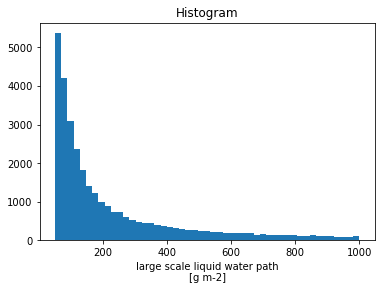

In [219]:
_ds = dic_ds['AEROCOMTRAJ']
(_ds['CWP']
 .where(_ds['r_eff']>1)
 .where(_ds['CWP']>50)
 .where(_ds['liq_frac_cwp']>0.95)
 .plot(bins= np.linspace(50,1000))
)

(array([5370., 4207., 3082., 2358., 1831., 1416., 1218.,  995.,  876.,
         721.,  734.,  612.,  532.,  477.,  448.,  435.,  390.,  367.,
         337.,  328.,  284.,  276.,  260.,  235.,  227.,  214.,  220.,
         183.,  198.,  193.,  180.,  190.,  144.,  153.,  146.,  125.,
         130.,  142.,  147.,  114.,  113.,  130.,  114.,  117.,  119.,
          93.,   94.,   87.,  103.]),
 array([  50.        ,   69.3877551 ,   88.7755102 ,  108.16326531,
         127.55102041,  146.93877551,  166.32653061,  185.71428571,
         205.10204082,  224.48979592,  243.87755102,  263.26530612,
         282.65306122,  302.04081633,  321.42857143,  340.81632653,
         360.20408163,  379.59183673,  398.97959184,  418.36734694,
         437.75510204,  457.14285714,  476.53061224,  495.91836735,
         515.30612245,  534.69387755,  554.08163265,  573.46938776,
         592.85714286,  612.24489796,  631.63265306,  651.02040816,
         670.40816327,  689.79591837,  709.18367347,  728.57142

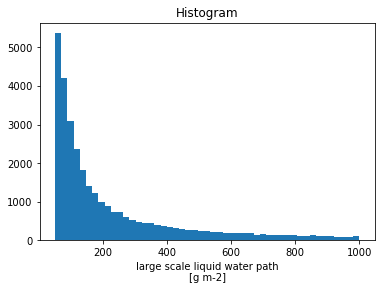

In [220]:
_ds = dic_ds['AEROCOMTRAJ']
(_ds['CWP']
 .where(_ds['r_eff']>1)
 .where(_ds['CWP']>50)
 .where(_ds['liq_frac_cwp']>0.95)
 .plot(bins= np.linspace(50,1000))
)

In [221]:
_ds = dic_ds['AEROCOMTRAJ']
(_ds['lwp']
 .where(_ds['r_eff2']>1)
 .where(_ds['CWP']>50)
 .where(_ds['liq_frac_cwp']>0.95)
 .quantile(.90)
)

<xarray.DataArray 'lwp' ()>
array(374.0234375)
Coordinates:
    quantile  float64 0.9
Attributes:
    long_name:        large scale liquid water path
    units:            g m-2
    um_stash_source:  m01s02i391
    frequency:        3hr

In [222]:

_ds = df_mod.to_xarray()

(array([8899., 4168., 2447., 1651., 1234.,  854.,  602.,  507.,  410.,
         353.]),
 array([ 50., 125., 200., 275., 350., 425., 500., 575., 650., 725., 800.],
       dtype=float32),
 <BarContainer object of 10 artists>)

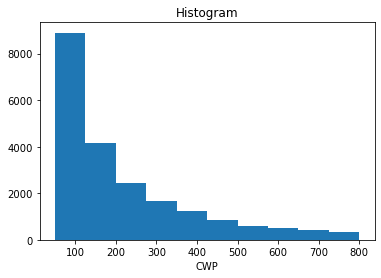

In [223]:
_ds['CWP'].plot()

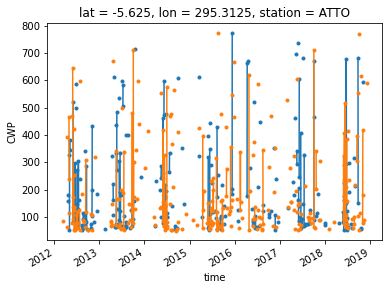

In [224]:
_ds['CWP'].isel(lat=0,lon=0).plot(marker='.')

_ds['CWP'].isel(lat=1,lon=1).plot(marker='.')

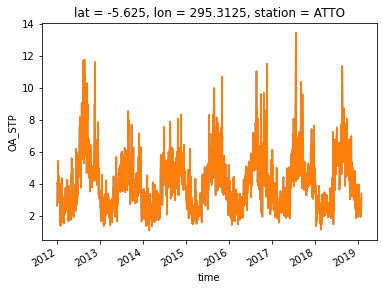

In [225]:
_ds['OA_STP'].isel(lat=0,lon=0).plot()

_ds['OA_STP'].isel(lat=1,lon=1).plot()

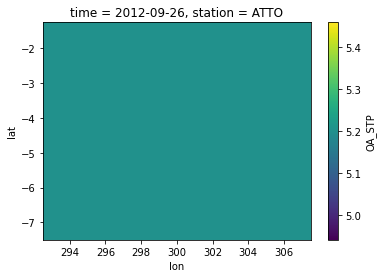

In [226]:
_ds['OA_STP'].isel(time=270).plot()

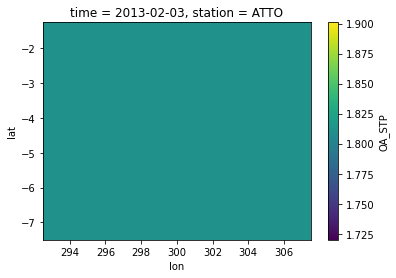

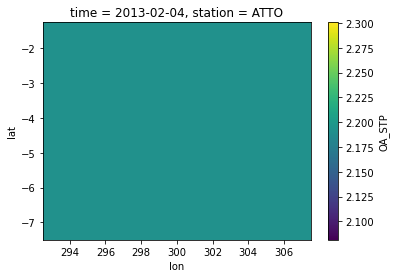

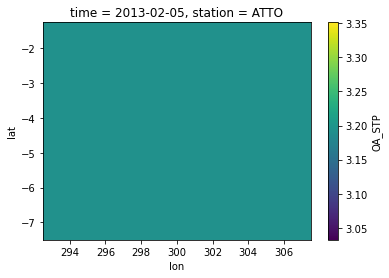

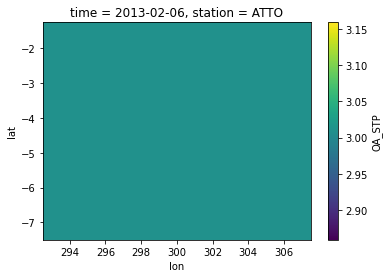

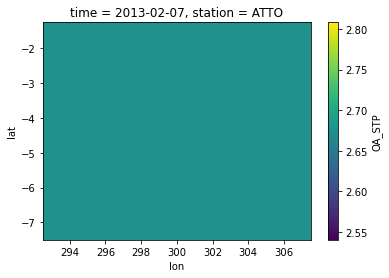

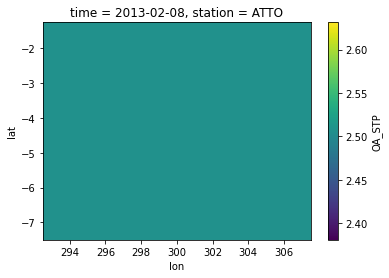

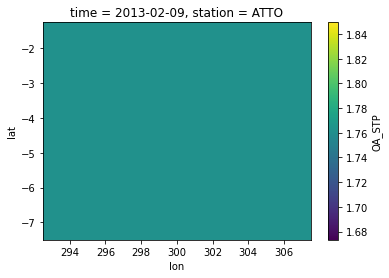

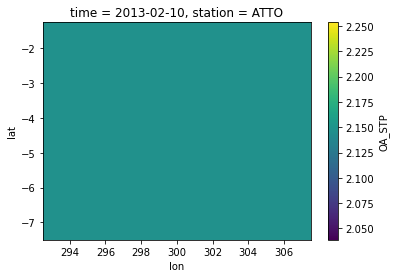

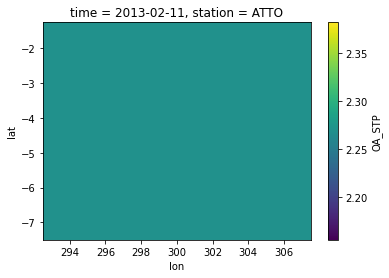

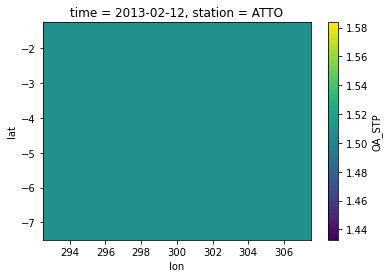

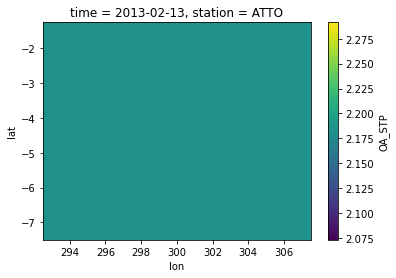

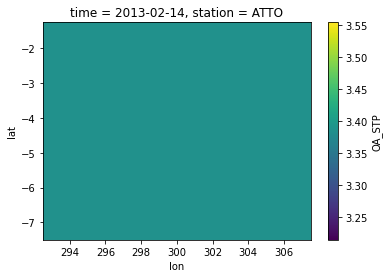

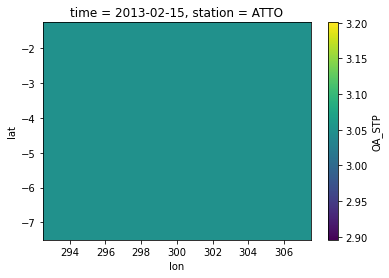

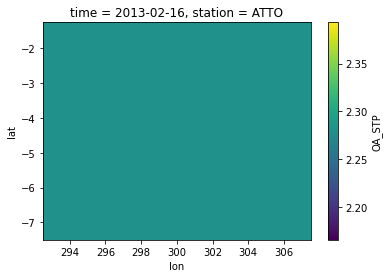

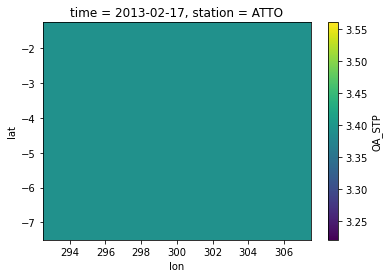

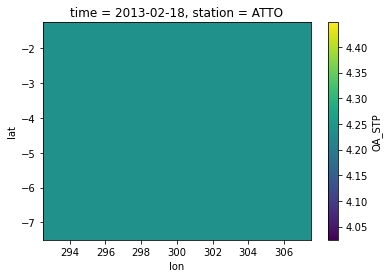

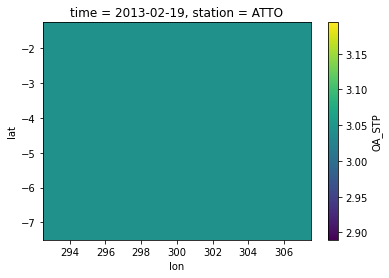

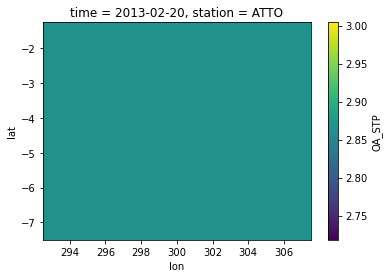

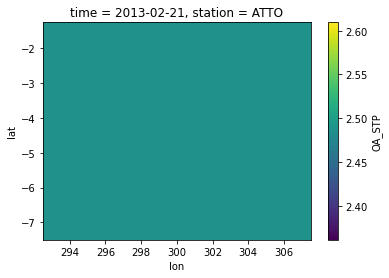

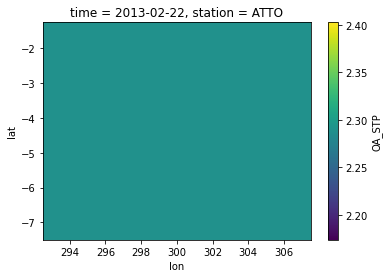

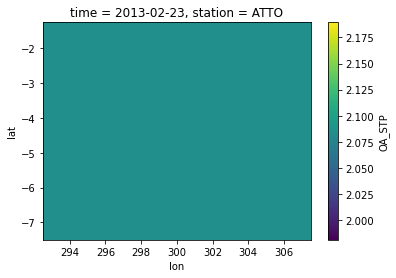

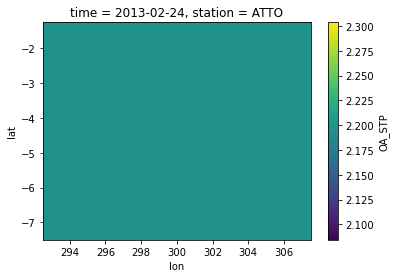

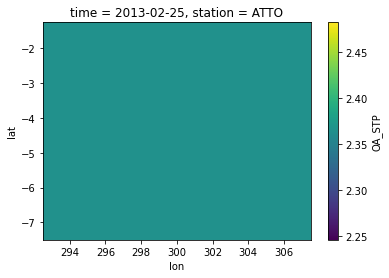

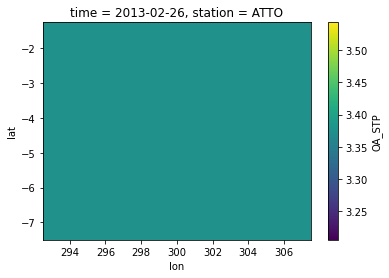

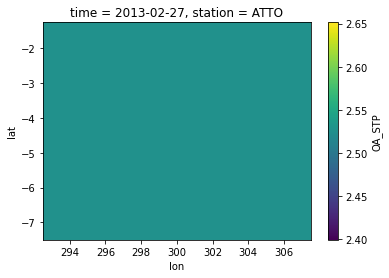

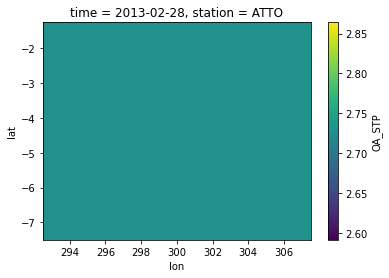

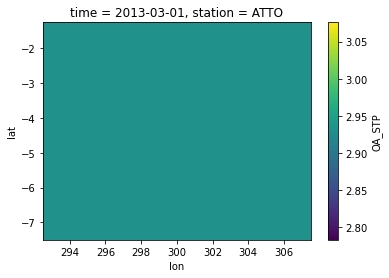

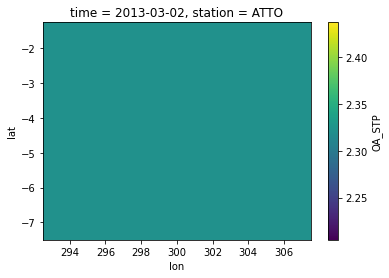

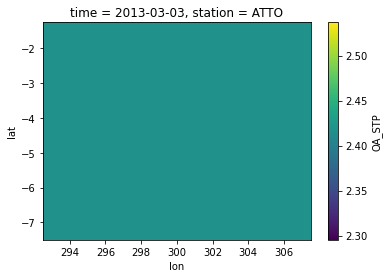

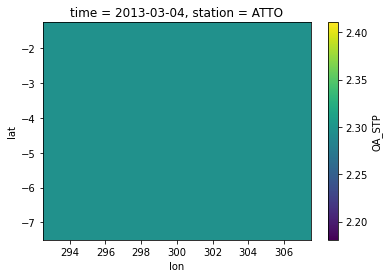

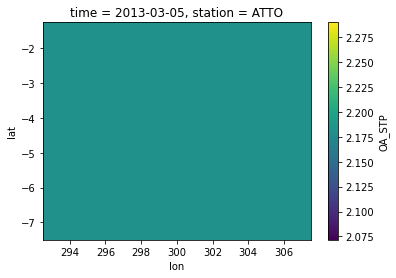

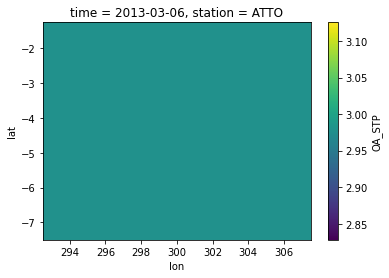

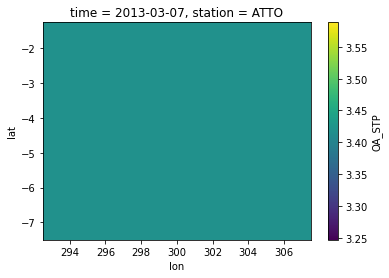

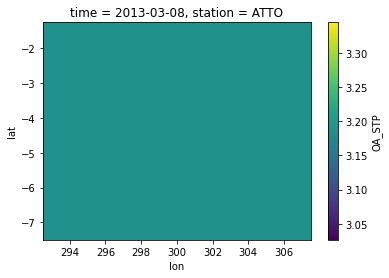

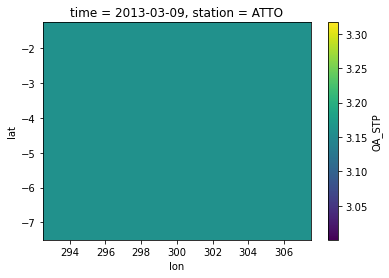

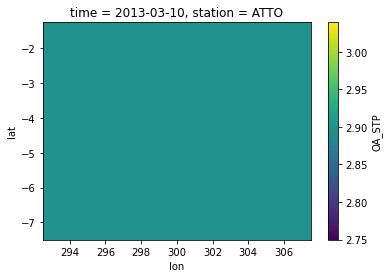

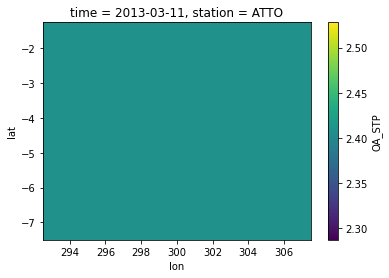

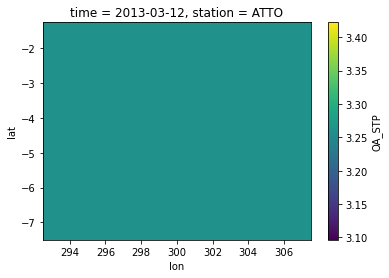

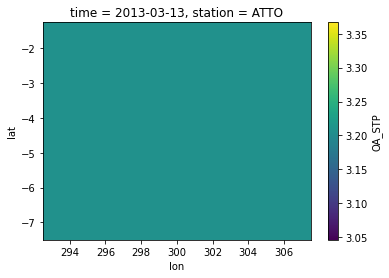

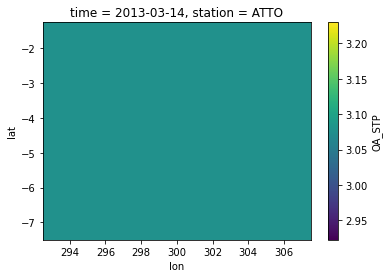

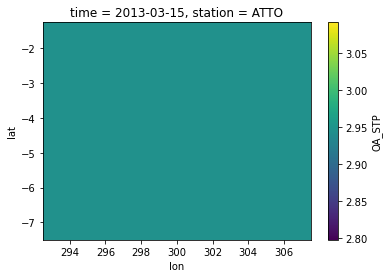

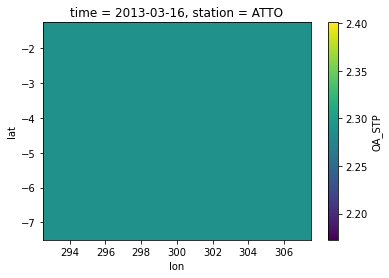

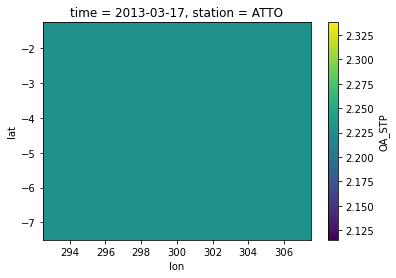

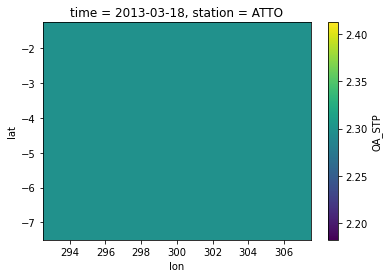

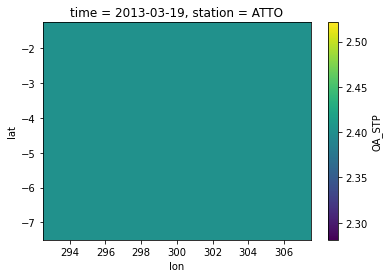

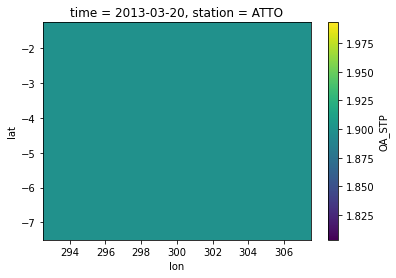

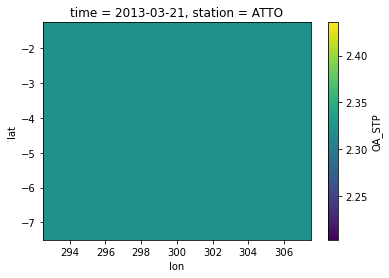

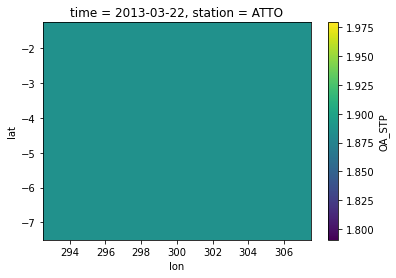

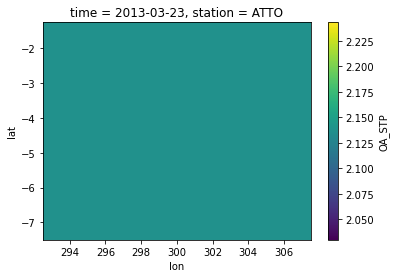

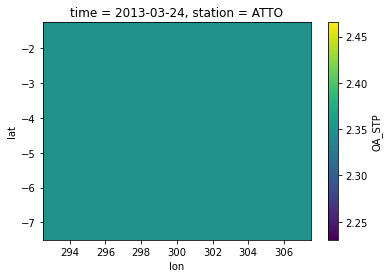

In [227]:
for i in range(0,50):
    _ds['OA_STP'].isel(time=(400+i)).plot()
    plt.show()


#### Add variables from station data to imitate using station measurements

In [228]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

In [229]:
print()

#### Moved to preprocess: Compute Nx-500